# The impact of customized head molds on motion and motion-related artifacts from structural and functional MRI scans in children

This is a notebook containing the analyses for the paper entitled "The impact of customized head molds on motion and motion-related artifacts from structural and functional MRI scans in children".

Weng, T. B., Vela, R. D., Weber, W., Dodla, M., Heinsfeld, A. S., Parker, S. D., Simon, B., Demeter, D. V., Nugiel, T., Whitmore, L., Mills, K. L., Church, J. A., Haberman, M. R., & Craddock, R. C. (2021). The impact of customized head molds on motion and motion-related artifacts from structural and functional MRI scans in children. MedRxiv, 2021.03.24.21253213. https://doi.org/10.1101/2021.03.24.21253213

## Abstract
Although neuroimaging provides powerful tools for assessing brain structure and function, their utility for elucidating mechanisms underlying neuropsychiatric disorders is limited by their sensitivity to head motion. Several publications have shown that standard retrospective motion correction and arduous quality assessment are insufficient to fully remove the deleterious impacts of motion on functional (fMRI) and structural (sMRI) neuroimaging data. These residual errors tend to be correlated with age and clinical diagnosis, resulting in artifactual findings in studies of clinical, developmental, and aging populations. As such there is a continued need to explore and evaluate novel methods for reducing head motion, and their applicability in these populations. Recently, a custom-fitted styrofoam head mold was reported to reduce motion across a range of ages, mostly adolescents, during a resting state fMRI scan.

In the present study, we tested the efficacy of these head molds in a sample exclusively of young children (N = 19; mean age = 7.9 years) including those with ADHD (N = 6). We evaluated the head mold’s impact on head motion, data quality, and analysis results derived from the data. Importantly, we also evaluated whether the head molds were tolerated by our population. We also assessed the extent to which the head mold’s efficacy was related to anxiety levels and ADHD symptoms. In addition to fMRI, we examined the head mold’s impact on sMRI by using a specialized sequence with embedded volumetric navigators (vNAV) to determine head motion during sMRI. We evaluated the head mold’s impact on head motion, data quality, and analysis results derived from the data. Additionally, we conducted acoustic measurements and analyses to determine the extent to which the head mold reduced the noise dosage from the scanner. We found that some individuals benefited while others did not improve significantly. One individual’s sMRI motion was made worse by the head mold. We were unable to identify predictors of the head mold response due to the smaller sample size. The head molds were tolerated well by young children, including those with ADHD, and they provided ample hearing protection. Although the head mold was not a universal solution for reducing head motion and improving data quality, we believe the time and cost required for using the head mold may outweigh the potential loss of data from excessive head motion for developmental studies.

## Analysis Plan

**Functional MRI Analyses**

- Does head motion differ between with and without the head mold?

- Does scan quality differ between with and without the head mold?

- Does the head mold reduce distance-dependent artifacts in functional connectivity analyses?

**Structural MRI Analyses**

- Does head motion differ between with and without the head mold?

- Does scan quality differ between with and without the head mold?

- Do volumetric estimates differ between head mold conditions?

**Behavioral Analyses**

- Do participants' tolerability ratings differ between with and without the head mold?

- Do the head molds affect the likelihood of returning for another MRI scan?

- Did participants prefer the MRI scan with or without the head mold?

In [1]:
import nibabel as nb
from nilearn.image.image import mean_img
from nilearn.plotting import plot_epi, show
from nilearn import input_data
import nibabel.processing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
import seaborn as sns
import pandas as pd
from scipy.stats.stats import pearsonr, ttest_ind

%load_ext rpy2.ipython

# Load data

In [2]:
# subject id with counterbalance group, experimental condition, and diagnosis

sub_coding = pd.read_csv('./data/sub_coding.csv')
sub_coding.replace({'ses': {1:'A',2:'B'}}, inplace = True)
sub_coding['sub'] = sub_coding['sub'].astype(str)
sub_coding['sub'] = sub_coding['sub'].apply(lambda x: x.zfill(3))
sub_coding['dx'] = sub_coding['dx'].map({'norm': 'TDC', 'adhd': 'ADHD'})
sub_coding['cond'] = sub_coding['cond'].map({'mold+': 'MOLD+', 'mold-': 'MOLD-'})
sub_coding.head()

,sub,ses,cond,dx
0,003,A,MOLD+,TDC
1,003,B,MOLD-,TDC
2,004,A,MOLD-,TDC
3,004,B,MOLD+,TDC
4,005,A,MOLD-,TDC


In [3]:
# demographics (age, counterbalance condition)

sub_demogs = pd.read_excel('./data/Motion_Demo&Scheduler.xlsx')
sub_demogs = sub_demogs[:21]
sub_demogs.rename(columns={"MRI SCREEN ID": "sub", "Age": "age"}, inplace = True)
sub_demogs.age = sub_demogs.age.astype(int)

sub_demogs['sub'] = sub_demogs['sub'].astype(str)
sub_demogs['sub'] = sub_demogs['sub'].apply(lambda x: x.zfill(3))

sub_demogs = sub_demogs[['sub', 'SWAN/SCARED RECORD', 'age']]

sub_demogs['SWAN/SCARED RECORD'] = sub_demogs['SWAN/SCARED RECORD'].astype(str)
sub_demogs['SWAN/SCARED RECORD'] = sub_demogs['SWAN/SCARED RECORD'].apply(lambda x: x.zfill(3))


sub_demogs = sub_demogs.merge(sub_coding[sub_coding['ses'] == 'A'], on = 'sub')


sub_demogs.head()

,sub,SWAN/SCARED RECORD,age,ses,cond,dx
0,003,014,10,A,MOLD+,TDC
1,004,015,7,A,MOLD-,TDC
2,005,016,9,A,MOLD-,TDC
3,007,011,8,A,MOLD-,TDC
4,008,013,5,A,MOLD+,TDC


# Perform some basic EDA on participant demographics

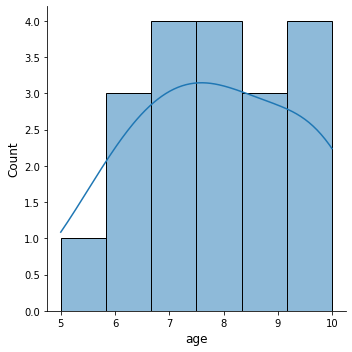

In [69]:
# plot distribution of age

sns.displot(data=sub_demogs, x="age", kde = True)

In [4]:
# load anxiety and adhd scores and join with sub_demogs table

swan_scared = pd.read_csv(r'./data/MotionRobustBrainMRI_DATA_LABELS_2020-10-14_1357.csv', encoding = 'iso-8859_1')
swan_scared = swan_scared[['Record ID', 'Panic Disorder or Significant Somatic Symptoms score',
                           'Generalized Anxiety Disorder Score',
                           'Separation Anxiety Disorder Score',
                           'Social Anxiety Disorder Score',
                           'School Avoidance Disorder Score', 'Total', 'ADHD Inattentive score', 'ADHD Hyperactive/Impulsive Score']][:21]

swan_scared.rename(columns={"Record ID": "SWAN/SCARED RECORD", 'Panic Disorder or Significant Somatic Symptoms score': 'Panic', 
                            'Generalized Anxiety Disorder Score': 'Generalized Anxiety',
                            'Separation Anxiety Disorder Score': 'Separation Anxiety',
                            'Social Anxiety Disorder Score': 'Social Anxiety',
                            'School Avoidance Disorder Score': 'School Avoidance', 
                            "Total": "total_anxiety"}, inplace = True)
swan_scared['SWAN/SCARED RECORD'] = swan_scared['SWAN/SCARED RECORD'].astype(int).astype(str)
swan_scared['SWAN/SCARED RECORD'] = swan_scared['SWAN/SCARED RECORD'].apply(lambda x: x.zfill(3))

sub_demogs = sub_demogs.merge(swan_scared, on = 'SWAN/SCARED RECORD', how = 'outer')
sub_demogs = sub_demogs[sub_demogs['sub'].notna()]

sub_demogs.drop(['ses', 'cond', 'SWAN/SCARED RECORD'], axis=1, inplace=True)

sub_demogs.head()

,sub,age,dx,Panic,Generalized Anxiety,Separation Anxiety,Social Anxiety,School Avoidance,total_anxiety,ADHD Inattentive score,ADHD Hyperactive/Impulsive Score
0,003,10.0,TDC,3.0,3.0,6.0,0.0,0.0,12.0,2.0,4.0
1,004,7.0,TDC,2.0,6.0,5.0,9.0,0.0,22.0,1.0,0.0
2,005,9.0,TDC,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,007,8.0,TDC,2.0,7.0,1.0,8.0,0.0,18.0,0.0,1.0
4,008,5.0,TDC,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# classify adhd subtype based on subscores

sub_demogs['ADHD_Subtype'] = ''
sub_demogs.loc[(sub_demogs['ADHD Inattentive score'] <= 6) & (sub_demogs['dx'] == 'ADHD'), 'ADHD_Subtype'] = 'ADHD-NOS'
sub_demogs.loc[sub_demogs['ADHD Inattentive score'] >= 6, 'ADHD_Subtype'] = 'ADHD-I'
sub_demogs.loc[sub_demogs['ADHD Hyperactive/Impulsive Score'] >= 6, 'ADHD_Subtype'] = 'ADHD-H'
sub_demogs.loc[(sub_demogs['ADHD Inattentive score'] >= 6) & (sub_demogs['ADHD Hyperactive/Impulsive Score'] >= 6), 'ADHD_Subtype'] = 'ADHD-C'


sub_demogs

,sub,age,dx,Panic,Generalized Anxiety,Separation Anxiety,Social Anxiety,School Avoidance,total_anxiety,ADHD Inattentive score,ADHD Hyperactive/Impulsive Score,ADHD_Subtype
0,003,10.0,TDC,3.0,3.0,6.0,0.0,0.0,12.0,2.0,4.0,
1,004,7.0,TDC,2.0,6.0,5.0,9.0,0.0,22.0,1.0,0.0,
2,005,9.0,TDC,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,
3,007,8.0,TDC,2.0,7.0,1.0,8.0,0.0,18.0,0.0,1.0,
4,008,5.0,TDC,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,
5,009,8.0,TDC,1.0,3.0,0.0,1.0,0.0,5.0,0.0,0.0,
6,010,7.0,TDC,1.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,
7,011,6.0,TDC,2.0,2.0,3.0,4.0,0.0,11.0,3.0,2.0,
8,012,8.0,TDC,1.0,1.0,1.0,0.0,0.0,3.0,4.0,2.0,
9,013,6.0,TDC,1.0,0.0,1.0,4.0,0.0,6.0,0.0,0.0,


In [6]:
sub_demogs_long = sub_demogs.melt(id_vars = ['sub', 'age', 'dx'])
sub_demogs_long.head()

,sub,age,dx,variable,value
0,003,10.0,TDC,Panic,3
1,004,7.0,TDC,Panic,2
2,005,9.0,TDC,Panic,NaN
3,007,8.0,TDC,Panic,2
4,008,5.0,TDC,Panic,0


In [52]:
sdf = sub_demogs.groupby('dx').agg(["mean", "std"]).T
idx = pd.IndexSlice
sdf.loc[idx[:,["std"]],idx[:]] = sdf.loc[idx[:,["std"]],idx[:]
                                               ].applymap(
                                               lambda x: "("+"{:.2f}".format(x)+")")


sdf.set_index(sdf.index.droplevel(level=1), inplace=True)

sdf = sdf.reset_index(drop=True)
sdf = pd.DataFrame(sdf.values, index=["Age", "", "Panic", "","General_Anxiety", 
                                      "","Separation_Anxiety", "","Social_Anxiety", 
                                      "","School_Avoidance", "","Total_Anxiety", "","ADHD-Inattentive", "", "ADHD-Hyperactive/Impulsive", ""], columns=["ADHD", "TDC"])

# sdf.to_csv('SWAN_SCARED_descriptives.csv')
print(sdf.to_csv())


,ADHD,TDC
Age,8.666666666666666,7.538461538461538
,(1.51),(1.51)
Panic,2.8333333333333335,1.25
,(4.67),(0.87)
General_Anxiety,4.833333333333333,2.75
,(5.42),(2.63)
Separation_Anxiety,3.0,1.75
,(3.16),(2.01)
Social_Anxiety,6.166666666666667,3.4166666666666665
,(2.93),(3.15)
School_Avoidance,0.0,0.08333333333333333
,(0.00),(0.29)
Total_Anxiety,16.833333333333332,8.538461538461538
,(14.97),(7.05)
ADHD-Inattentive,6.666666666666667,1.0
,(1.21),(1.41)
ADHD-Hyperactive/Impulsive,4.5,0.75
,(3.56),(1.29)



In [189]:
sdf

dx                                          ADHD       TDC
age                              mean   8.666667  7.538462
                                 std    1.505545  1.506397
Panic                            mean   2.833333  1.250000
                                 std    4.665476  0.866025
Generalized Anxiety              mean   4.833333  2.750000
                                 std    5.419102  2.632835
Separation Anxiety               mean   3.000000  1.750000
                                 std    3.162278  2.005674
Social Anxiety                   mean   6.166667  3.416667
                                 std    2.926887  3.146667
School Avoidance                 mean   0.000000  0.083333
                                 std    0.000000  0.288675
total_anxiety                    mean  16.833333  8.538462
                                 std   14.972196  7.054731
ADHD Inattentive score           mean   6.666667  1.000000
                                 std    1.211060  1.414214
ADHD Hyperactive/Impulsive Score mean   4.500000  0.750000
                                 std    3.563706  1.288057

In [245]:
for ind, df in sdf.groupby(level=0):


ADHD Hyperactive/Impulsive Score,0.75 (1.29),4.50 (3.56) 
ADHD Inattentive score,1.00 (1.41),6.67 (1.21) 
Generalized Anxiety,2.75 (2.63),4.83 (5.42) 
Panic,1.25 (0.87),2.83 (4.67) 
School Avoidance,0.08 (0.29),0.00 (0.00) 
Separation Anxiety,1.75 (2.01),3.00 (3.16) 
Social Anxiety,3.42 (3.15),6.17 (2.93) 
age,7.54 (1.51),8.67 (1.51) 
total_anxiety,8.54 (7.05),16.83 (14.97) 


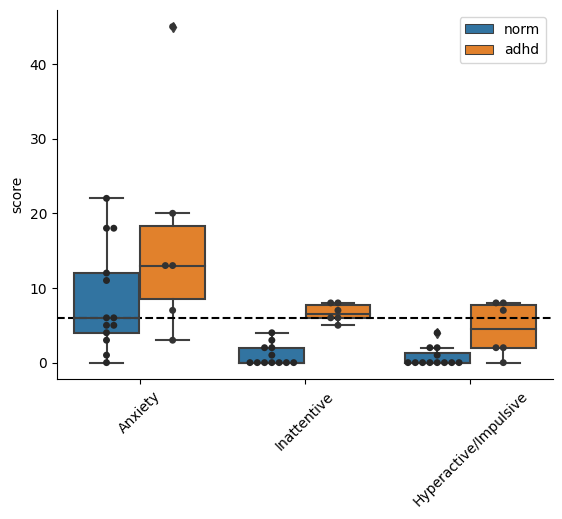

In [165]:
# compare anxiety and adhd scores for ADHD vs TDC

plt.rcdefaults()
plt.clf()

ax = sns.boxplot(x='variable', y = 'value', hue = 'dx', data = sub_demogs_long)
ax = sns.swarmplot(x='variable', y = 'value', hue = 'dx', color = '.2', dodge = True, data = sub_demogs_long)
plt.xticks([0,1,2], ['Total Anxiety', 'Inattentive', 'Hyperactive/Impulsive'], rotation=45)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.set(ylabel = 'score', xlabel = '')
plt.axhline(y=6, color='black', linestyle='--')
sns.despine()
plt.show()


# voxel-to-voxel time series correlation and distance between voxel pairs

This analysis computes the Euclidean distance between every ROI pair (264 x 264 matrix) as well as the functional connectivity, measured as Pearson’s correlation between pairs of regions from the 264 regions of interest (ROIs) atlas (Power et al., 2011) between ROI pairs. These two matrices served as the basis for assessing whether head molds impacted distance-dependent motion artifacts in functional connectivity analyses.


In [71]:
# load preprocessed func

func_list = sorted(glob.glob('./sub-*/output/pipeline_analysis_nuisance/sub-*_ses-*/motion_correct_to_standard_smooth/_scan_movie/_fwhm_4/sub*ses*maths.nii.gz'))

func = func_list[0]
func_list[0:3]

['./sub-003/output/pipeline_analysis_nuisance/sub-003_ses-A/motion_correct_to_standard_smooth/_scan_movie/_fwhm_4/sub-003_ses-A_task-movie_bold_calc_tshift_resample_volreg_antswarp_maths.nii.gz',
 './sub-003/output/pipeline_analysis_nuisance/sub-003_ses-B/motion_correct_to_standard_smooth/_scan_movie/_fwhm_4/sub-003_ses-B_task-movie_bold_calc_tshift_resample_volreg_antswarp_maths.nii.gz',
 './sub-004/output/pipeline_analysis_nuisance/sub-004_ses-A/motion_correct_to_standard_smooth/_scan_movie/_fwhm_4/sub-004_ses-A_task-movie_bold_calc_tshift_resample_volreg_antswarp_maths.nii.gz']

In [ ]:
# resample to 2mm
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

template = load_mni152_template()

# parallel code
from joblib import Parallel, delayed
    
def resample(func):
    resampled_img = resample_to_img(func, template)
    resampled_img.to_filename(func.replace('.nii.gz', '_2mm.nii.gz'))
    return resampled_img

pooled_subjects = Parallel(n_jobs=4)(delayed(resample)(func_file) for func_file in func_list)



In [ ]:
!parallel --progress  --plus 'singularity exec $SCRATCH/fcpindi_c-pac_latest-1.5.0.sif flirt -in {} -ref /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz -out {/.nii.gz/_2mm.nii.gz} -applyxfm' ::: `find /scratch/06028/tbweng/child-motion/derivatives/preproc_081720/sub-*/output/pipeline_analysis_nuisance/sub-*_ses-*/motion_correct_to_standard_smooth/_scan_movie/_fwhm_4/sub*ses*maths.nii.gz`

In [76]:
# func_resampled_list = sorted(glob.glob('./sub-*/output/pipeline_analysis_nuisance/sub-*_ses-*/functional_to_standard/_scan_movie/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_M-SDB_P-2/residuals_antswarp_2mm.nii.gz'))
func_resampled_list = sorted(glob.glob('./sub-*/output/pipeline_analysis_nuisance/sub-*_ses-*/motion_correct_to_standard_smooth/_scan_movie/_fwhm_4/sub*ses*_2mm.nii.gz'))


In [77]:
#drop 020
func_resampled_list = [ x for x in func_resampled_list if "sub-020" not in x ]

In [78]:
len(func_resampled_list)

38

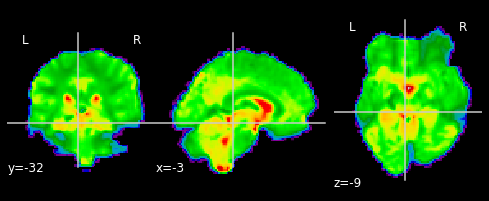

In [79]:
# check data
plot_epi(mean_img(func_resampled_list[0]))

# load Power ROIs

In [556]:
from nilearn import datasets

power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

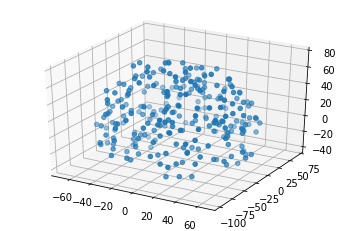

In [101]:
# plot all rois
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(power.rois['x'], power.rois['y'], power.rois['z'])

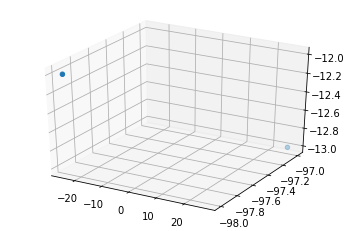

In [83]:
# plot first 2 ROIs
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(power.rois['x'][0:2], power.rois['y'][0:2], power.rois['z'][0:2])

In [102]:
print(coords[0], coords[1])

[-25 -98 -12] [ 27 -97 -13]


In [85]:
# euclidean dist between first 2 ROIs
np.linalg.norm(coords[0]-coords[1])

52.01922721455981

# extract time series

In [86]:
spheres_masker = input_data.NiftiSpheresMasker(
    seeds=coords, radius=5.,
    standardize=True, detrend=True)


In [87]:

pooled_subjects = []

# parallel code
from joblib import Parallel, delayed
    
def extract_ts(func_file):
    time_series = spheres_masker.fit_transform(func_file)
    pooled_subjects.append(time_series)
    np.savetxt(func_file.split('/')[4] + '_no_denoise_ts.txt', time_series, delimiter=' ')
    return time_series

pooled_subjects = Parallel(n_jobs=4)(delayed(extract_ts)(func_file) for func_file in func_resampled_list)

len(pooled_subjects)

38

In [ ]:
timeseries.shape

In [ ]:
# plot timeseries random 5 rois
plt.plot(timeseries[:, np.random.randint(265, size=5)])

plt.tight_layout()

# save correlation matrices

In [88]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(pooled_subjects)

In [89]:
# Save individual correlation matrices for each subject

for i in range(correlation_matrices.shape[0]):
    
    # index the func_file name for the subject number
    filename = func_resampled_list[i].split('/')[4] + '_no_denoise_corrmat.txt'
    
    np.savetxt(filename, correlation_matrices[i,:,:], fmt = '%.5f')

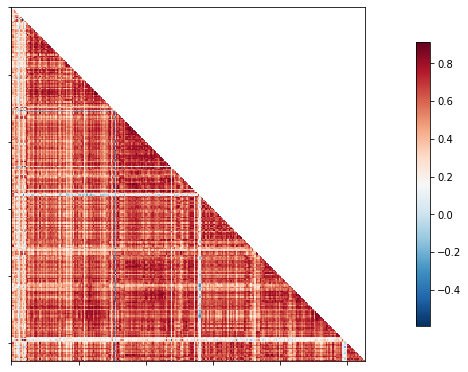

In [90]:
# plot example corr mat
from nilearn import plotting
plotting.plot_matrix(correlation_matrices[0,:,:], tri='lower', colorbar=True)


In [ ]:
correlation_matrices[0,:,:].shape

# get matrix of roi pair distances

In [557]:
roi = []
for i in range(len(coords)):
    dist = []
    for j in range(len(coords)):
        dist.append(np.linalg.norm(coords[i]-coords[j]))
    roi.append(dist)
    
# df = df.append(pd.DataFrame(dist))
# #         np.linalg.norm(coords[i]-coords[j+1])

distance_matrix = np.array([np.array(e) for e in roi])
distance_matrix.shape

(264, 264)

In [ ]:
m = np.triu(distance_matrix)

In [ ]:
m

In [ ]:
distance_matrix[np.tril_indices(distance_matrix.shape[0], -1)] = np.nan

In [ ]:
distance_matrix

In [558]:
df = [ c for c in zip(*distance_matrix) ]

In [ ]:
np.savetxt('test.out', np.transpose(df), delimiter = ' ')

In [559]:
df = pd.DataFrame(df)

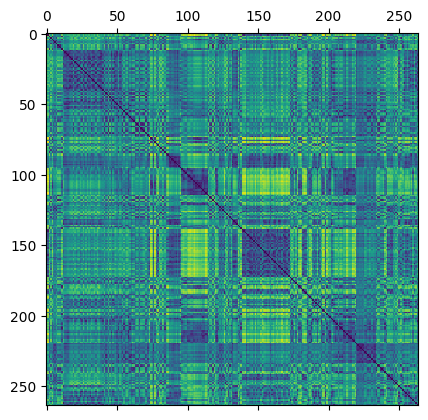

In [302]:
plt.matshow(df)
plt.show()

In [ ]:
df

In [ ]:
plt.matshow(m)
plt.show()

In [560]:
distance_matrix_trim = distance_matrix[np.triu_indices(264, k = 1)][500:]
distance_matrix_trim = distance_matrix_trim[:-500]
len(distance_matrix_trim)

33716

In [561]:
def smooth(a,WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

In [562]:
dist_arr = distance_matrix[np.triu_indices(264, k = 1)]
dist_arr_sorted = np.sort(dist_arr)
dist_arr_trim = dist_arr[np.logical_and(dist_arr>=35, dist_arr<=100)] #roi pair dist between 35 and 100mm

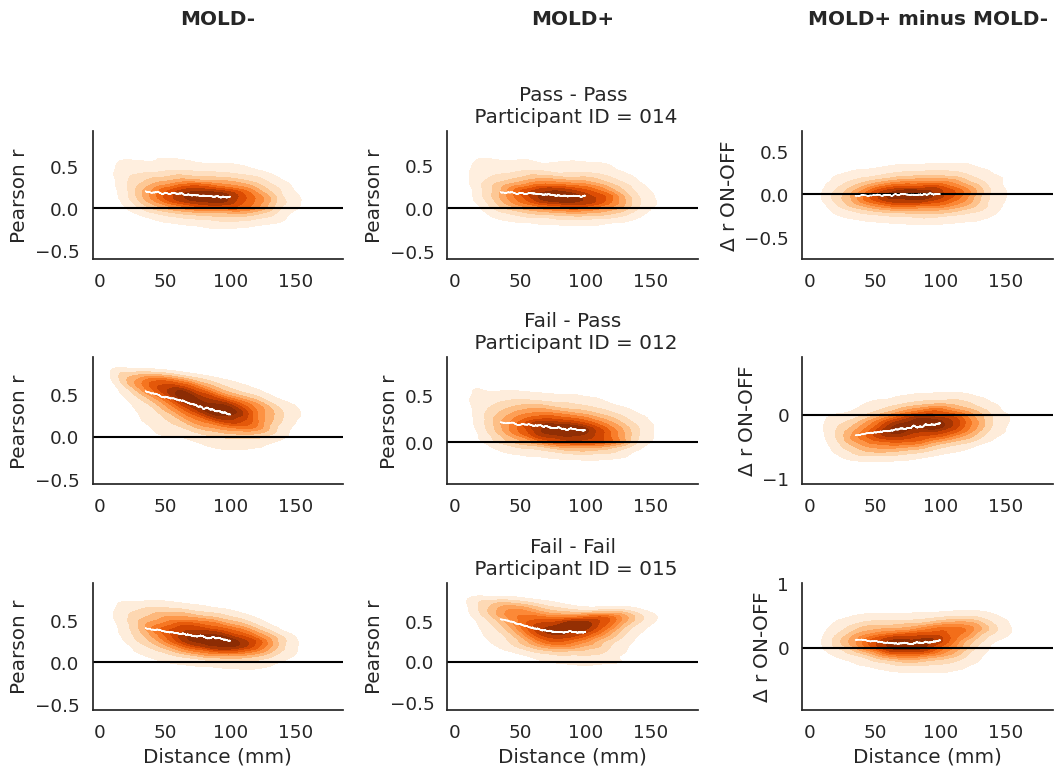

In [564]:
fig, axes = plt.subplots(4,3, figsize=(11, 8), facecolor='w', edgecolor='k', gridspec_kw={"height_ratios":[0.001,1,1,1]})
fig.subplots_adjust(hspace = .1, wspace=.5, bottom=0.1)
    
sns.set(style="white", font_scale=1.2)
sns.despine()

plt.setp(axes[-1, :], xlabel='Distance (mm)')
axes[0,0].set_title("MOLD-", fontweight='bold')
axes[0,0].axis("off")
axes[0,1].set_title("MOLD+", fontweight='bold')
axes[0,1].axis("off")
axes[0,2].set_title("MOLD+ minus MOLD-", fontweight='bold')
axes[0,2].axis("off")

axes[1,1].set_title('Pass - Pass\n Participant ID = 014')
axes[2,1].set_title('Fail - Pass\n Participant ID = 012')
axes[3,1].set_title('Fail - Fail\n Participant ID = 015')
    
for c in axes[1:4]:
    for ax in c:
        ax.axhline(y=0, color='black', linestyle='-')
            
sublist = ['014', '012', '015']

for i in range(len(sublist)):
    sub = sublist[i]
    mold_on = np.loadtxt('_'.join(['./sub-' + sub, 'mold+', 'no_denoise_corrmat.txt']))
    mold_off = np.loadtxt('_'.join(['./sub-' + sub, 'mold-', 'no_denoise_corrmat.txt']))
    delta_r = mold_on - mold_off



    
    # plot mold-
    corr_arr = mold_off[np.triu_indices(264, k = 1)]
    corr_arr_smooth = smooth(corr_arr[np.argsort(dist_arr)], 1001)
    corr_arr_smooth_trim = corr_arr_smooth[np.logical_and(dist_arr_sorted>=35, dist_arr_sorted<=100)]
    
    sns.kdeplot(ax = axes[i+1,0], x=np.sort(dist_arr), y=corr_arr[np.argsort(dist_arr)], cmap="Oranges", shade=True)
    sns.lineplot(ax = axes[i+1,0], x=np.sort(dist_arr_trim), y=corr_arr_smooth_trim, color='white', linewidth = 1)
    axes[i+1,0].set(ylabel=r'Pearson r')
    
    
    # plot mold+
    corr_arr = mold_on[np.triu_indices(264, k = 1)]
    corr_arr_smooth = smooth(corr_arr[np.argsort(dist_arr)], 1001)
    corr_arr_smooth_trim = corr_arr_smooth[np.logical_and(dist_arr_sorted>=35, dist_arr_sorted<=100)]
    
    sns.kdeplot(ax = axes[i+1,1], x=np.sort(dist_arr), y=corr_arr[np.argsort(dist_arr)], cmap="Oranges", shade=True)
    sns.lineplot(ax = axes[i+1,1], x=np.sort(dist_arr_trim), y=corr_arr_smooth_trim, color='white', linewidth = 1)
   
    axes[i+1,1].set(ylabel=r'Pearson r')
    
    
    
    # plot change    
    delta_r_arr = delta_r[np.triu_indices(264, k = 1)]
    delta_r_arr_smooth = smooth(delta_r_arr[np.argsort(dist_arr)], 1001)
    delta_r_arr_smooth_trim = delta_r_arr_smooth[np.logical_and(dist_arr_sorted>=35, dist_arr_sorted<=100)]                   

    
    # ax = sns.scatterplot(x=dist_arr_sorted, y=delta_r_arr[np.argsort(dist_arr)], marker = '.', size = 2, color = 'red', linewidth=0)
    sns.kdeplot(ax = axes[i+1,2], x=np.sort(dist_arr), y=delta_r_arr[np.argsort(dist_arr)], cmap="Oranges", shade=True)
    sns.lineplot(ax = axes[i+1,2], x=np.sort(dist_arr_trim), y=delta_r_arr_smooth_trim, color='white', linewidth = 1)
    axes[i+1,2].set(ylabel=r'$\Delta$ r ON-OFF')
    
plt.tight_layout()

fig.savefig('figs/fc_distance.png',dpi = 300)
plt.show()  

# group average corrmats

In [567]:
arr_list = []
mold_on_group = []
mold_off_group = []
# list of corrmats
for sub in sub_coding['sub'].unique():
    mold_on = np.loadtxt('_'.join(['./sub-' + sub, 'mold+', 'no_denoise_corrmat.txt']))
    mold_off = np.loadtxt('_'.join(['./sub-' + sub, 'mold-', 'no_denoise_corrmat.txt']))
    delta_r = mold_on - mold_off
    arr_list.append(delta_r)
    mold_on_group.append(mold_on)
    mold_off_group.append(mold_off)
    
# mean of all corrmats
delta_r_groupmean = np.mean(arr_list, axis=0).reshape(264, 264)
mold_on_groupmean = np.mean(mold_on_group, axis=0).reshape(264, 264)
mold_off_groupmean = np.mean(mold_off_group, axis=0).reshape(264, 264)

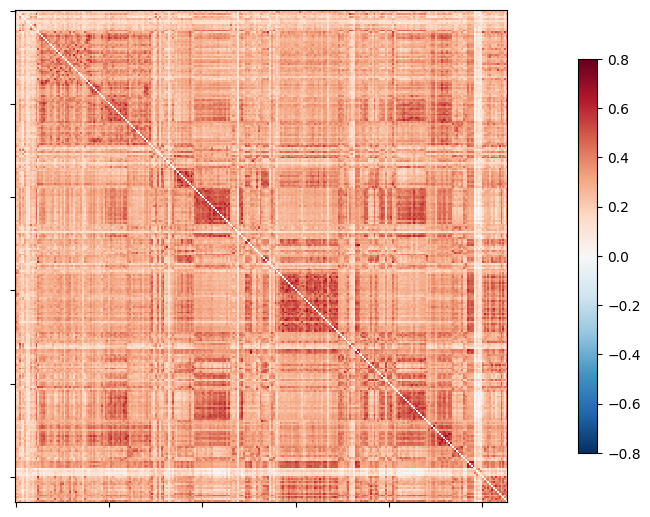

In [163]:
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(mold_off_groupmean, 0)
plotting.plot_matrix(mold_off_groupmean, colorbar=True,
                     vmax=0.8, vmin=-0.8)

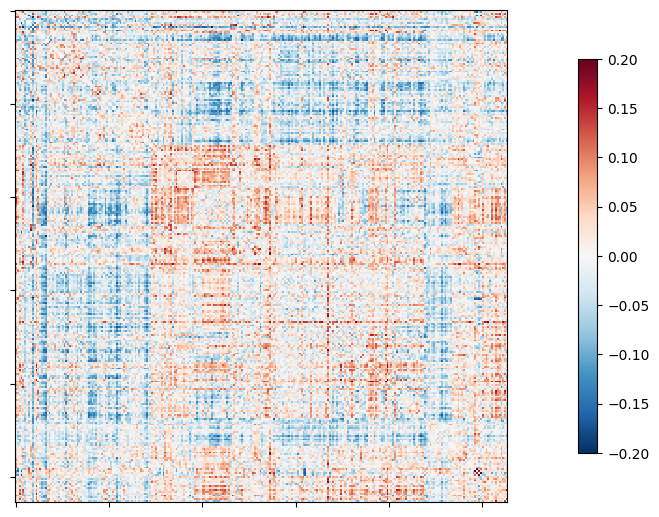

In [241]:

np.fill_diagonal(delta_r_groupmean, 0)
plotting.plot_matrix(delta_r_groupmean, colorbar=True,
                     vmax=0.2, vmin=-0.2)

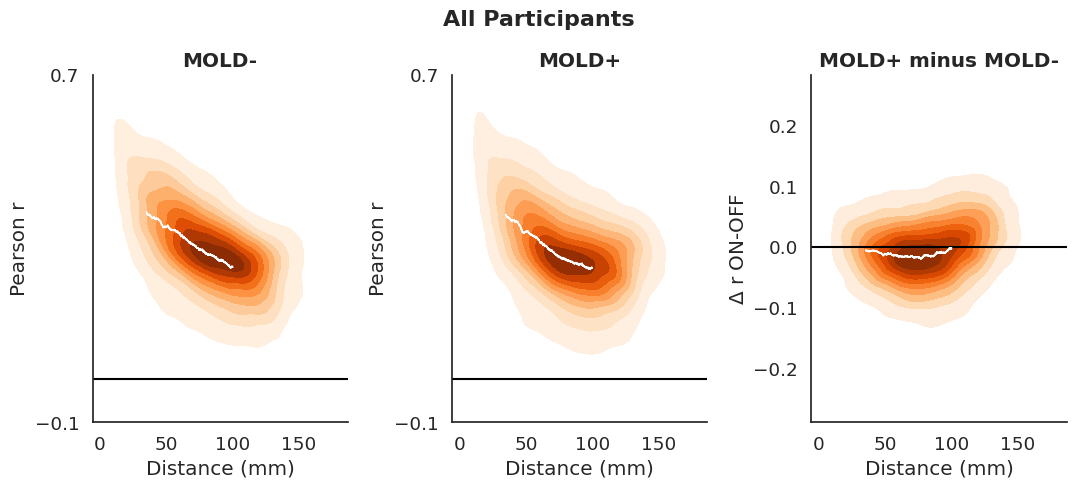

In [625]:

fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(11, 5), sharey = False, facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .1, wspace=.5, bottom=0.1)
    
sns.set(style="white", font_scale=1.2)
sns.despine()

for ax in axes.flat:
    ax.set(xlabel='Distance (mm)')
    
# plt.setp(axes[-1, :], xlabel='Distance (mm)')
axes[0].set_title("MOLD-", fontweight='bold')
# axes[0].axis("off")
axes[1].set_title("MOLD+", fontweight='bold')
# axes[1].axis("off")
axes[2].set_title("MOLD+ minus MOLD-", fontweight='bold')
# axes[2].axis("off")

fig.suptitle("All Participants", fontsize=16, fontweight = 'bold')

    
axes[0].axhline(y=0, c="black",linestyle='-')
axes[1].axhline(y=0, c="black",linestyle='-')
axes[2].axhline(y=0, c="black",linestyle='-')


# plot mold-
mold_off_groupmean_arr = mold_off_groupmean[np.triu_indices(264, k = 1)]
mold_off_groupmean_arr_smooth = smooth(mold_off_groupmean_arr[np.argsort(dist_arr)], 1001)
mold_off_groupmean_arr_smooth_trim = mold_off_groupmean_arr_smooth[np.logical_and(dist_arr_sorted>=35, dist_arr_sorted<=100)]



sns.kdeplot(ax = axes[0], x=np.sort(dist_arr), y=mold_off_groupmean_arr[np.argsort(dist_arr)], cmap="Oranges", shade=True)
sns.lineplot(ax = axes[0], x=np.sort(dist_arr_trim), y=mold_off_groupmean_arr_smooth_trim, color='white', linewidth = 1)
axes[0].set(ylabel=r'Pearson r')
axes[0].set_ylim([-.1, .7])
axes[0].set_yticks([-.1, .7])

# plot mold+
mold_on_groupmean_arr = mold_on_groupmean[np.triu_indices(264, k = 1)]
mold_on_groupmean_arr_smooth = smooth(mold_on_groupmean_arr[np.argsort(dist_arr)], 1001)
mold_on_groupmean_arr_smooth_trim = mold_on_groupmean_arr_smooth[np.logical_and(dist_arr_sorted>=35, dist_arr_sorted<=100)]

sns.kdeplot(ax = axes[1], x=np.sort(dist_arr), y=mold_on_groupmean_arr[np.argsort(dist_arr)], cmap="Oranges", shade=True)
sns.lineplot(ax = axes[1], x=np.sort(dist_arr_trim), y=mold_on_groupmean_arr_smooth_trim, color='white', linewidth = 1)

axes[1].set(ylabel=r'Pearson r')
axes[1].set_ylim([-.1, .7])
axes[1].set_yticks([-.1, .7])

# plot change    
delta_r_groupmean_arr = delta_r_groupmean[np.triu_indices(264, k = 1)]
delta_r_groupmean_arr_smooth = smooth(delta_r_groupmean_arr[np.argsort(dist_arr)], 1001)
delta_r_groupmean_arr_smooth_trim = delta_r_groupmean_arr_smooth[np.logical_and(dist_arr_sorted>=35, dist_arr_sorted<=100)]


sns.kdeplot(ax = axes[2], x=np.sort(dist_arr), y=delta_r_groupmean_arr[np.argsort(dist_arr)], cmap="Oranges", shade=True)
sns.lineplot(ax = axes[2], x=np.sort(dist_arr_trim), y=delta_r_groupmean_arr_smooth_trim, color='white', linewidth = 1)
axes[2].set(ylabel=r'$\Delta$ r ON-OFF')
    
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig('figs/fc_distance_group.png',dpi = 300)
plt.show()  

In [164]:
delta_r_groupmean_arr = delta_r_groupmean[np.triu_indices(264, k = 1)]
delta_r_groupmean_arr_smooth = smooth(delta_r_groupmean_arr[np.argsort(dist_arr)], 1001)
delta_r_groupmean_arr_smooth_trim = delta_r_groupmean_arr_smooth[np.logical_and(dist_arr_sorted>=35, dist_arr_sorted<=100)]


# Analysis of head motion (FD) during fMRI scans and its impact on scan quality

# plot some example FD and DVARS traces

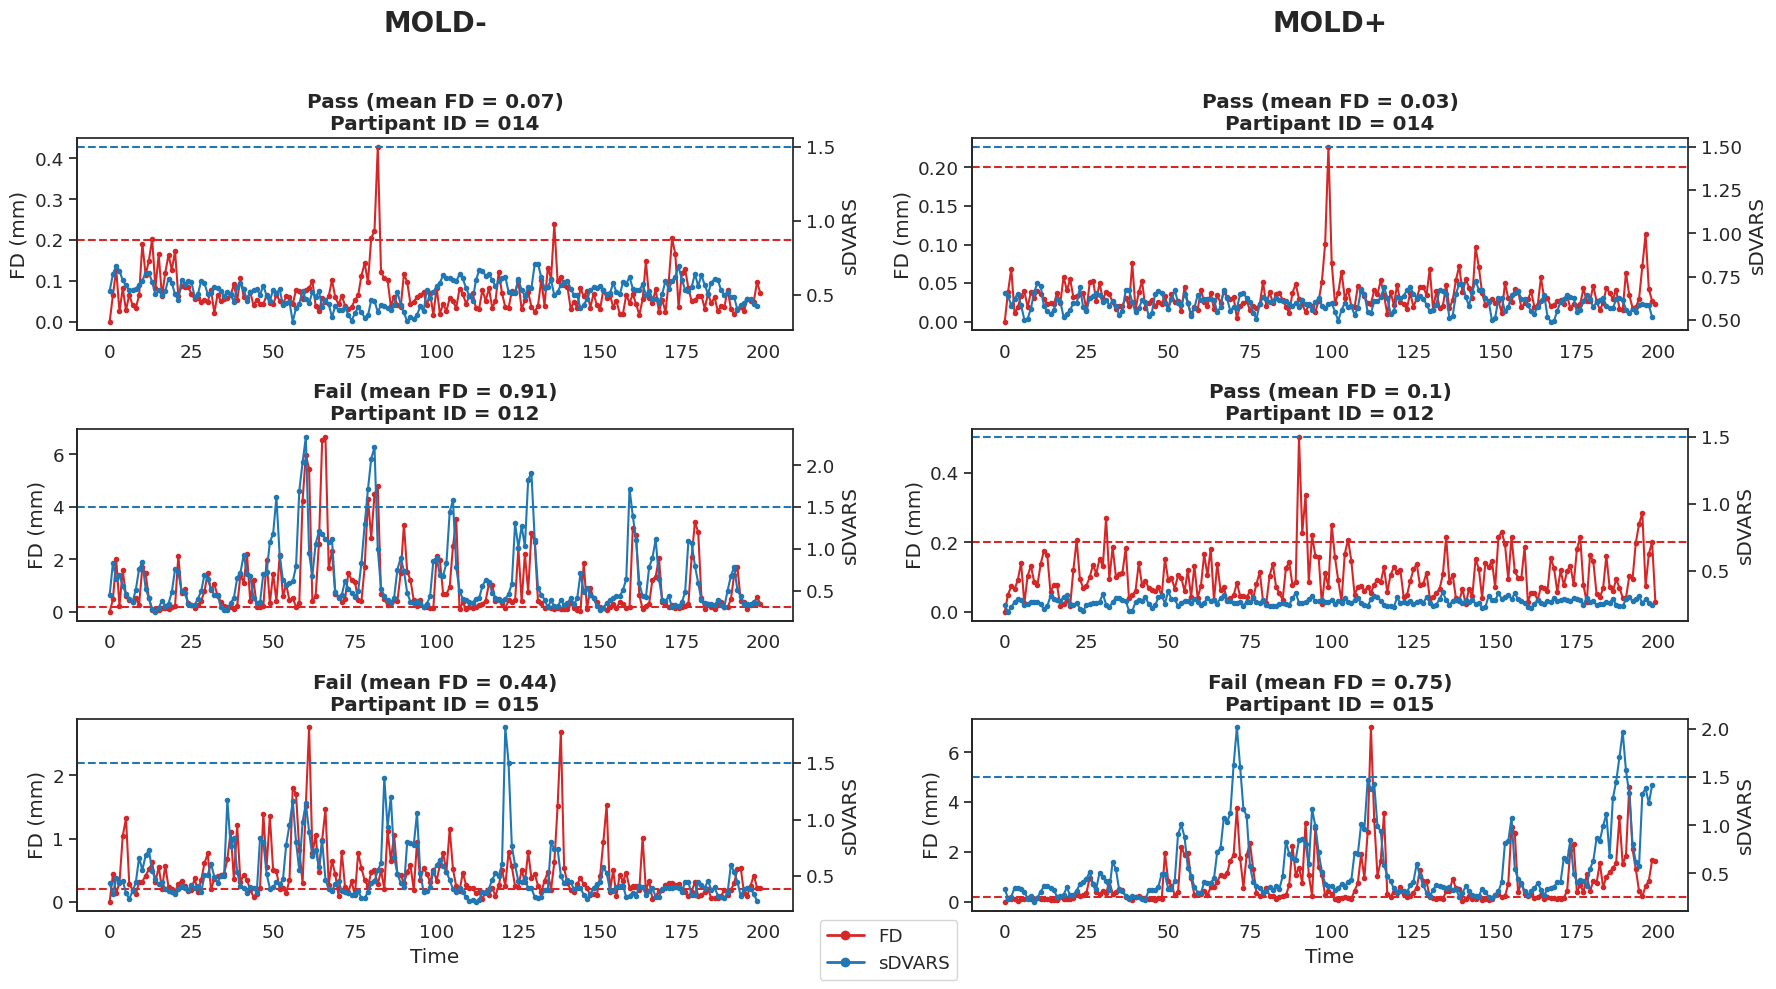

In [31]:


def two_scales(ax1, data1, data2):
    ax2 = ax1.twinx()
    ax1.plot(data1, color='tab:red', marker = 'o', markersize = 3)
    ax1.axhline(y=0.2, color='tab:red', linestyle='--')
    ax1.set_ylabel('FD (mm)')

    
    ax2.plot(data2, color='tab:blue', marker = 'o', markersize = 3)
    ax2.set_ylabel('sDVARS')
    ax2.axhline(y=1.5, color='tab:blue', linestyle='--')

    return ax1, ax2

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(18, 10), facecolor='w', edgecolor='k', gridspec_kw={"height_ratios":[0.001,2,2,2]})
fig.subplots_adjust(hspace = .1, wspace=.5, bottom=0.1)

sns.set(style="white", font_scale=1.2)
sns.despine()


plt.setp(axes[-1, :], xlabel='Time')
axes[0,0].set_title("MOLD-", fontweight='bold', fontsize = 20)
axes[0,0].axis("off")
axes[0,1].set_title("MOLD+", fontweight='bold', fontsize = 20)
axes[0,1].axis("off")


for i, sub in enumerate([ 'sub-014', 'sub-012', 'sub-015' ]):
    for j, cond in enumerate(['mold-', 'mold+']):
        subID = sub.strip('sub-')
        ses = sub_coding.loc[(sub_coding['sub'] == sub.strip('./sub-')) & (sub_coding['cond'] == cond), 'ses'].item()
        dvars_arr = np.loadtxt('./' + sub.strip('sub-') + '_ses-' + ses + '_dvars.txt')
        fd_arr = np.loadtxt('./' + sub + '/output/pipeline_analysis_nuisance/' + sub + '_ses-' + ses + '/frame_wise_displacement_power/_scan_movie/FD.1D')
        if np.mean(fd_arr) < 0.2:
            axes[i+1,j].set_title('Pass (mean FD = ' + str(round(np.mean(fd_arr),2)) + ')\n' + 'Partipant ID = ' + subID, fontweight='bold')
        elif np.mean(fd_arr) >= 0.2:
             axes[i+1,j].set_title('Fail (mean FD = ' + str(round(np.mean(fd_arr),2)) + ')\n' + 'Partipant ID = ' + subID, fontweight='bold')

        axes[i+1,j] = two_scales(axes[i+1,j], fd_arr, dvars_arr)


from matplotlib.lines import Line2D

colors = ['tab:red', 'tab:blue']
lines = [Line2D([0], [0], color=c,  marker='o', linewidth=2, linestyle='-') for c in colors]
labels = ['FD', 'sDVARS']
fig.legend(lines, labels, loc='lower center')


fig.set_facecolor('w')
plt.tight_layout()
fig.savefig('figs/fc_traces.png',dpi = 300)
plt.show()

In [7]:
# extract FD

li = []

for i in sorted(glob.glob('./sub-*/output/pipeline_analysis_nuisance/sub-*_ses-*/frame_wise_displacement_power/_scan_movie/FD.1D')):
    sub = i.split('/')[1].split('-')[1]
    ses = i.split('/')[4].split('_')[1].split('-')[1]
    fd_arr = np.loadtxt(i)
    fd_arr_scrubbed = fd_arr[fd_arr <=.3]
    mean_fd = np.mean(fd_arr)
    mean_fd_scrubbed = np.mean(fd_arr_scrubbed)
    li.append([sub, ses, mean_fd, mean_fd_scrubbed, 100*((len(fd_arr) - len(fd_arr_scrubbed))/len(fd_arr))])
                             
fd_df = pd.DataFrame(li, columns = ['sub', 'ses', 'mean_fd', 'mean_fd_scrubbed', 'perc_over_pt3'])
fd_df = sub_coding.merge(fd_df, on = ['sub', 'ses'])


# join with demogs data
fd_df = fd_df.merge(sub_demogs[['sub', 'age', 'total_anxiety', 'ADHD_Subtype']], on = 'sub')

fd_df.age = fd_df.age.astype(int).astype(str)

# convert to mm/min
fd_df['mean_fd_transformed'] = 30 * fd_df.mean_fd

fd_df.head()

,sub,ses,cond,dx,mean_fd,mean_fd_scrubbed,perc_over_pt3,age,total_anxiety,ADHD_Subtype,mean_fd_transformed
0,003,A,MOLD+,TDC,0.108958,0.078444,6.5,10,12.0,,3.268725
1,003,B,MOLD-,TDC,0.318773,0.138316,24.5,10,12.0,,9.563186
2,004,A,MOLD-,TDC,0.181140,0.116458,15.5,7,22.0,,5.434199
3,004,B,MOLD+,TDC,0.193985,0.129838,15.0,7,22.0,,5.819547
4,005,A,MOLD-,TDC,0.326496,0.146423,27.0,9,0.0,,9.794884


In [8]:
# label pass/fail based on quality control thresholds (Fail: FD > 0.2 mm)

fd_df.loc[fd_df['mean_fd'] <= .2, 'rating'] = 1
fd_df.loc[fd_df['mean_fd'] > .2, 'rating'] = 0

fd_df.loc[fd_df['perc_over_pt3'] <= 20, 'rating_perc_fd'] = 1
fd_df.loc[fd_df['perc_over_pt3'] > 20, 'rating_perc_fd'] = 0

fd_df.rating = fd_df.rating.astype(int)
fd_df.rating_perc_fd = fd_df.rating.astype(int)
fd_df.head()

,sub,ses,cond,dx,mean_fd,mean_fd_scrubbed,perc_over_pt3,age,total_anxiety,ADHD_Subtype,mean_fd_transformed,rating,rating_perc_fd
0,003,A,MOLD+,TDC,0.108958,0.078444,6.5,10,12.0,,3.268725,1,1
1,003,B,MOLD-,TDC,0.318773,0.138316,24.5,10,12.0,,9.563186,0,0
2,004,A,MOLD-,TDC,0.181140,0.116458,15.5,7,22.0,,5.434199,1,1
3,004,B,MOLD+,TDC,0.193985,0.129838,15.0,7,22.0,,5.819547,1,1
4,005,A,MOLD-,TDC,0.326496,0.146423,27.0,9,0.0,,9.794884,0,0


In [10]:
fd_df_long = fd_df.melt(id_vars = ['sub', 'ses', 'cond', 'dx', 'mean_fd', 'mean_fd_scrubbed', 'perc_over_pt3', 'age', 'total_anxiety', 'ADHD_Subtype' ] )
fd_df_long.head()

,sub,ses,cond,dx,mean_fd,mean_fd_scrubbed,perc_over_pt3,age,total_anxiety,ADHD_Subtype,variable,value
0,003,A,MOLD+,TDC,0.108958,0.078444,6.5,10,12.0,,mean_fd_transformed,3.268725
1,003,B,MOLD-,TDC,0.318773,0.138316,24.5,10,12.0,,mean_fd_transformed,9.563186
2,004,A,MOLD-,TDC,0.181140,0.116458,15.5,7,22.0,,mean_fd_transformed,5.434199
3,004,B,MOLD+,TDC,0.193985,0.129838,15.0,7,22.0,,mean_fd_transformed,5.819547
4,005,A,MOLD-,TDC,0.326496,0.146423,27.0,9,0.0,,mean_fd_transformed,9.794884


In [629]:
fd_df_wide = pd.pivot_table(fd_df, values = ['rating', 'rating_perc_fd'], index=['sub', 'dx', 'age', 'total_anxiety','ADHD_Subtype'], columns = 'cond')
fd_df_wide.head()



rating       rating_perc_fd      
cond                                    MOLD+ MOLD-          MOLD+ MOLD-
sub dx  age total_anxiety ADHD_Subtype                                  
003 TDC 10  12.0                            1     0              1     0
004 TDC 7   22.0                            1     1              1     1
005 TDC 9   0.0                             0     0              0     0
007 TDC 8   18.0                            1     0              1     0
008 TDC 5   1.0                             1     1              1     1

In [11]:
fd_df_wide_ses = pd.pivot_table(fd_df, values = ['rating', 'rating_perc_fd'], index=['sub', 'dx', 'age', 'total_anxiety','ADHD_Subtype'], columns = 'ses')
fd_df_wide_ses.head()


rating    rating_perc_fd   
ses                                         A  B              A  B
sub dx  age total_anxiety ADHD_Subtype                            
003 TDC 10  12.0                            1  0              1  0
004 TDC 7   22.0                            1  1              1  1
005 TDC 9   0.0                             0  0              0  0
007 TDC 8   18.0                            0  1              0  1
008 TDC 5   1.0                             1  1              1  1

In [630]:
fd_df_wide.columns = ['_'.join(col).rstrip('_') for col in fd_df_wide.columns.values]
fd_df_wide.head()

,,,,,rating_MOLD+,rating_MOLD-,rating_perc_fd_MOLD+,rating_perc_fd_MOLD-
sub,dx,age,total_anxiety,ADHD_Subtype,,,,
003,TDC,10,12.0,,1,0,1,0
004,TDC,7,22.0,,1,1,1,1
005,TDC,9,0.0,,0,0,0,0
007,TDC,8,18.0,,1,0,1,0
008,TDC,5,1.0,,1,1,1,1


In [12]:
fd_df_wide_ses.columns = ['_'.join(col).rstrip('_') for col in fd_df_wide_ses.columns.values]
fd_df_wide_ses.head()

,,,,,rating_A,rating_B,rating_perc_fd_A,rating_perc_fd_B
sub,dx,age,total_anxiety,ADHD_Subtype,,,,
003,TDC,10,12.0,,1,0,1,0
004,TDC,7,22.0,,1,1,1,1
005,TDC,9,0.0,,0,0,0,0
007,TDC,8,18.0,,0,1,0,1
008,TDC,5,1.0,,1,1,1,1


In [633]:
fd_df_wide['rating_qc_diff'] = fd_df_wide['rating_MOLD+'] - fd_df_wide['rating_MOLD-']
fd_df_wide['rating_perc_fd_qc_diff'] = fd_df_wide['rating_perc_fd_MOLD+'] - fd_df_wide['rating_perc_fd_MOLD-']

fd_df_wide.loc[(fd_df_wide['rating_qc_diff'] == 0) & (fd_df_wide['rating_MOLD+'] == 0), 'fd_rating'] = 'fail-fail'
fd_df_wide.loc[(fd_df_wide['rating_qc_diff'] == 0) & (fd_df_wide['rating_MOLD+'] == 1), 'fd_rating'] = 'pass-pass'
fd_df_wide.loc[fd_df_wide['rating_qc_diff'] == 1, 'fd_rating'] = 'fail-pass'
fd_df_wide.loc[fd_df_wide['rating_qc_diff'] == -1, 'fd_rating'] = 'pass-fail'

fd_df_wide.loc[(fd_df_wide['rating_perc_fd_qc_diff'] == 0) & (fd_df_wide['rating_perc_fd_MOLD+'] == 0), 'perc_fd_rating'] = 'fail-fail'
fd_df_wide.loc[(fd_df_wide['rating_perc_fd_qc_diff'] == 0) & (fd_df_wide['rating_perc_fd_MOLD+'] == 1), 'perc_fd_rating'] = 'pass-pass'
fd_df_wide.loc[fd_df_wide['rating_perc_fd_qc_diff'] == 1, 'perc_fd_rating'] = 'fail-pass'
fd_df_wide.loc[fd_df_wide['rating_perc_fd_qc_diff'] == -1, 'perc_fd_rating'] = 'pass-fail'

fd_df_wide

,,,,,rating_MOLD+,rating_MOLD-,rating_perc_fd_MOLD+,rating_perc_fd_MOLD-,rating_qc_diff,rating_perc_fd_qc_diff,fd_rating,perc_fd_rating
sub,dx,age,total_anxiety,ADHD_Subtype,,,,,,,,
003,TDC,10,12.0,,1,0,1,0,1,1,fail-pass,fail-pass
004,TDC,7,22.0,,1,1,1,1,0,0,pass-pass,pass-pass
005,TDC,9,0.0,,0,0,0,0,0,0,fail-fail,fail-fail
007,TDC,8,18.0,,1,0,1,0,1,1,fail-pass,fail-pass
008,TDC,5,1.0,,1,1,1,1,0,0,pass-pass,pass-pass
009,TDC,8,5.0,,1,0,1,0,1,1,fail-pass,fail-pass
010,TDC,7,4.0,,1,1,1,1,0,0,pass-pass,pass-pass
011,TDC,6,11.0,,0,0,0,0,0,0,fail-fail,fail-fail
012,TDC,8,3.0,,1,0,1,0,1,1,fail-pass,fail-pass


In [83]:
fd_df_wide_ses['rating_qc_diff'] = fd_df_wide_ses['rating_B'] - fd_df_wide_ses['rating_A']
fd_df_wide_ses['rating_perc_fd_qc_diff'] = fd_df_wide_ses['rating_perc_fd_B'] - fd_df_wide_ses['rating_perc_fd_A']

fd_df_wide_ses.loc[(fd_df_wide_ses['rating_qc_diff'] == 0) & (fd_df_wide_ses['rating_B'] == 0), 'fd_rating'] = 'fail-fail'
fd_df_wide_ses.loc[(fd_df_wide_ses['rating_qc_diff'] == 0) & (fd_df_wide_ses['rating_B'] == 1), 'fd_rating'] = 'pass-pass'
fd_df_wide_ses.loc[fd_df_wide_ses['rating_qc_diff'] == 1, 'fd_rating'] = 'fail-pass'
fd_df_wide_ses.loc[fd_df_wide_ses['rating_qc_diff'] == -1, 'fd_rating'] = 'pass-fail'

fd_df_wide_ses.loc[(fd_df_wide_ses['rating_perc_fd_qc_diff'] == 0) & (fd_df_wide_ses['rating_perc_fd_B'] == 0), 'perc_fd_rating'] = 'fail-fail'
fd_df_wide_ses.loc[(fd_df_wide_ses['rating_perc_fd_qc_diff'] == 0) & (fd_df_wide_ses['rating_perc_fd_B'] == 1), 'perc_fd_rating'] = 'pass-pass'
fd_df_wide_ses.loc[fd_df_wide_ses['rating_perc_fd_qc_diff'] == 1, 'perc_fd_rating'] = 'fail-pass'
fd_df_wide_ses.loc[fd_df_wide_ses['rating_perc_fd_qc_diff'] == -1, 'perc_fd_rating'] = 'pass-fail'


fd_df_wide_ses

,index,sub,dx,age,total_anxiety,ADHD_Subtype,rating_A,rating_B,rating_perc_fd_A,rating_perc_fd_B,rating_qc_diff,fd_rating,rating_perc_fd_qc_diff,perc_fd_rating
0,0,003,TDC,10,12.0,,1,0,1,0,-1,pass-fail,-1,pass-fail
1,1,004,TDC,7,22.0,,1,1,1,1,0,pass-pass,0,pass-pass
2,2,005,TDC,9,0.0,,0,0,0,0,0,fail-fail,0,fail-fail
3,3,007,TDC,8,18.0,,0,1,0,1,1,fail-pass,1,fail-pass
4,4,008,TDC,5,1.0,,1,1,1,1,0,pass-pass,0,pass-pass
5,5,009,TDC,8,5.0,,1,0,1,0,-1,pass-fail,-1,pass-fail
6,6,010,TDC,7,4.0,,1,1,1,1,0,pass-pass,0,pass-pass
7,7,011,TDC,6,11.0,,0,0,0,0,0,fail-fail,0,fail-fail
8,8,012,TDC,8,3.0,,0,1,0,1,1,fail-pass,1,fail-pass
9,9,013,TDC,6,6.0,,0,1,0,1,1,fail-pass,1,fail-pass


In [14]:
fd_df_wide_ses.reset_index(inplace=True)
fd_df_wide_ses.age = fd_df_wide_ses.age.astype(int)

fd_df_wide_ses.reset_index(inplace=True)
fd_df_wide_ses.age = fd_df_wide_ses.age.astype(int)

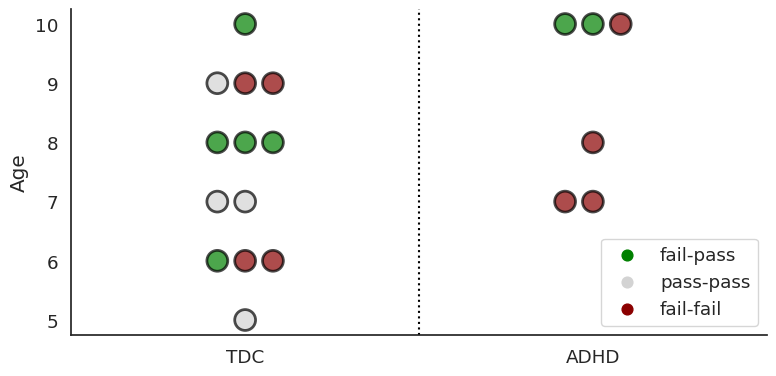

In [208]:
# plot scan quality changes from MOLD- to MOLD+ as a function of ADHD diagnosis and age

sns.set(style="white", font_scale=1.2)
fig, ax = plt.subplots(figsize=(8, 4))

sns.swarmplot(x = 'dx', y = 'age', hue = 'fd_rating', size = 15, data = fd_df_wide, 
              palette = ['green', 'lightgray', 'darkred'], linewidth = 2, 
              edgecolor = 'black', alpha = .7)

ax.set_xlabel('') 
ax.axvline(.5, ls=':', color = 'black')
plt.ylabel('Age')
ax.set_xticklabels(['TDC', 'ADHD'])

plt.legend(loc='lower right',numpoints=1)


sns.despine()
plt.tight_layout()
plt.savefig('figs/fd_swarmplot_dx_age.png', dpi = 300)
plt.show()


In [235]:
fd_df_wide.head()

,sub,dx,age,total_anxiety,ADHD Subtype,rating_MOLD+,rating_MOLD-,rating_perc_fd_MOLD+,rating_perc_fd_MOLD-,rating_qc_diff,rating_perc_fd_qc_diff,fd_rating,perc_fd_rating
0,003,TDC,10,12.0,,1,0,1,0,1,1,fail-pass,fail-pass
1,004,TDC,7,22.0,,1,1,1,1,0,0,pass-pass,pass-pass
2,005,TDC,9,0.0,,0,0,0,0,0,0,fail-fail,fail-fail
3,007,TDC,8,18.0,,1,0,1,0,1,1,fail-pass,fail-pass
4,008,TDC,5,1.0,,1,1,1,1,0,0,pass-pass,pass-pass


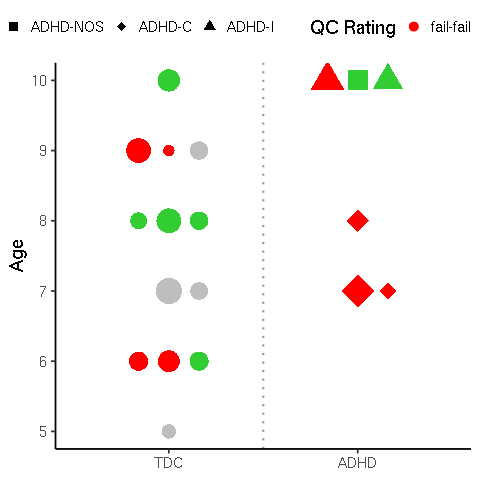

In [762]:
# add info about ADHD subtypes and anxiety scores

%%R -i fd_df_wide

library(ggbeeswarm)
fd_df_wide$ADHD_Subtype[fd_df_wide$ADHD_Subtype=='']='Sub-threshold'

fd_df_wide$ADHD_Subtype <- factor(fd_df_wide$ADHD_Subtype, levels = c("Sub-threshold", "ADHD-NOS", "ADHD-C", "ADHD-I"))



beeswarm <- ggplot(fd_df_wide, aes(dx, age, group = fd_rating, fill=fd_rating, color = fd_rating, shape = ADHD_Subtype, size = total_anxiety)) +
    geom_beeswarm(aes(shape=ADHD_Subtype,color=fd_rating, fill=fd_rating),cex = 8) +  
    scale_shape_manual(breaks = c("ADHD-NOS", "ADHD-C", "ADHD-I"), values = c(16,15,18,17), "ADHD Subtype") +
    scale_color_manual(values = c('red', 'limegreen', 'grey'), "QC Rating") +
    scale_fill_manual(values = c('red', 'limegreen', 'grey'), "QC Rating") + 
    scale_size(range = c(5, 15), guide = 'none') +
    scale_x_discrete(limits=c("TDC", "ADHD")) +
    geom_vline(xintercept=1.5, linetype="dotted", color = "black", size = 1, alpha = .4) +
    guides(shape = guide_legend(override.aes = list(size=4))) + 
    guides(color = guide_legend(override.aes = list(size=4))) +
    labs(y = "Age") + theme_classic(base_size=18) + theme(axis.title.x = element_blank()) + theme(legend.position="top")

    
plot(beeswarm) 


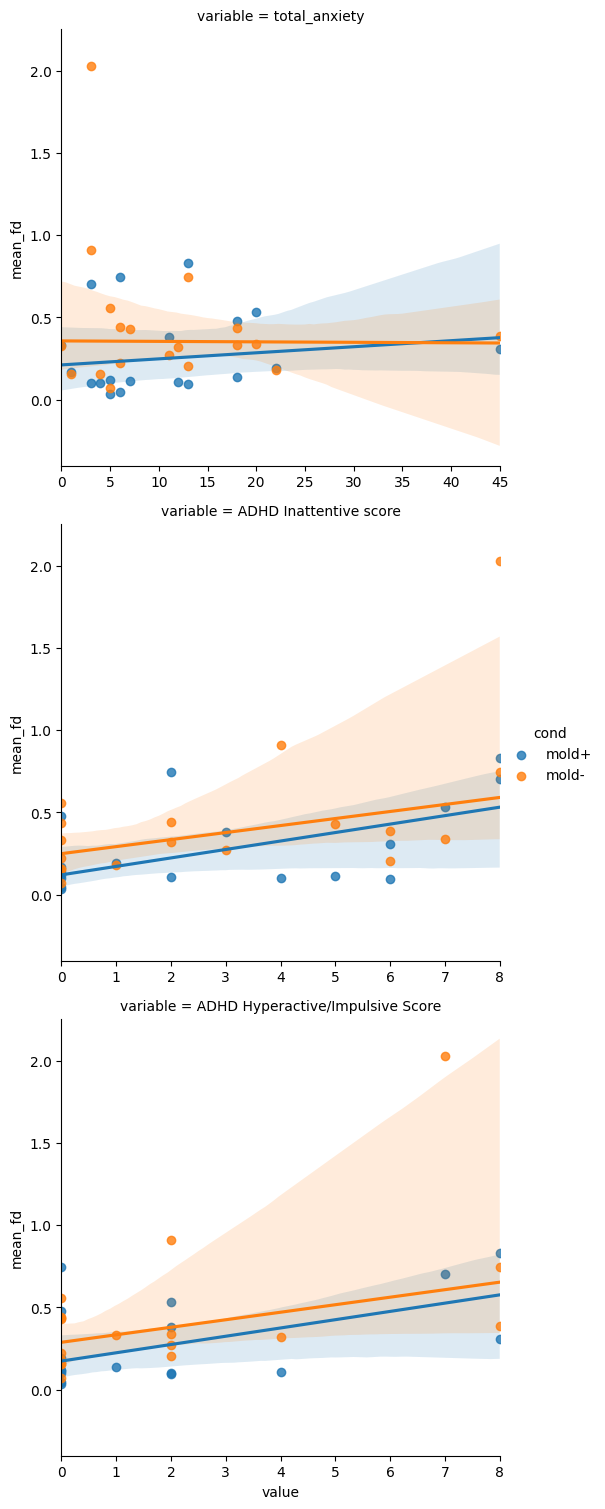

In [161]:
# correlate motion with anxiety scores and ADHD scores
g = sns.lmplot(x="value", y="mean_fd", hue="cond", robust = False,
               row = 'variable', data=fd_df_long, sharex= False)


# plot mean head motion as a function of ADHD subtype and QC impact

In [103]:
fd_df_wide.head()

,sub,dx,age,ADHD Subtype,rating_mold+,rating_mold-,rating_perc_fd_mold+,rating_perc_fd_mold-,rating_qc_diff,rating_perc_fd_qc_diff,fd_rating,perc_fd_rating
0,003,TDC,10,,1,0,1,0,1,1,fail-pass,fail-pass
1,004,TDC,7,,1,1,1,1,0,0,pass-pass,pass-pass
2,005,TDC,9,,0,0,0,0,0,0,fail-fail,fail-fail
3,007,TDC,8,,1,0,1,0,1,1,fail-pass,fail-pass
4,008,TDC,5,,1,1,1,1,0,0,pass-pass,pass-pass


In [75]:
%%R 

# dtt$model <- factor(dtt$model, levels=c("mb", "ma", "mc"), labels=c("MBB", "MAA", "MCC"))
factor(fd_df_wide$rating, levels=c("pass-pass", )

'data.frame':	19 obs. of  7 variables:
 $ sub    : chr  "003" "004" "005" "007" ...
 $ dx     : chr  "norm" "norm" "norm" "norm" ...
 $ age    : int  10 7 9 8 5 8 7 6 8 6 ...
 $ mold+  : int  1 1 0 1 1 1 1 0 1 1 ...
 $ mold-  : int  0 1 0 0 1 0 1 0 0 0 ...
 $ qc_diff: int  1 0 0 1 0 1 0 0 1 1 ...
 $ rating : chr  "fail-pass" "pass-pass" "fail-fail" "fail-pass" ...


In [575]:
fd_df_wide['dx'] = fd_df_wide['dx'].map({1: 'TDC', 2: 'ADHD'})

In [464]:
%%R -i fd_df -i fd_df_wide
merge(fd_df %>% select(sub, cond), fd_df_wide, by = 'sub')

   sub  cond dx age total_anxiety ADHD_Subtype rating_MOLD+ rating_MOLD-
1  003 MOLD+  1  10            12                         1            0
2  003 MOLD-  1  10            12                         1            0
3  004 MOLD-  1   7            22                         1            1
4  004 MOLD+  1   7            22                         1            1
5  005 MOLD-  1   9             0                         0            0
6  005 MOLD+  1   9             0                         0            0
7  007 MOLD-  1   8            18                         1            0
8  007 MOLD+  1   8            18                         1            0
9  008 MOLD+  1   5             1                         1            1
10 008 MOLD-  1   5             1                         1            1
11 009 MOLD+  1   8             5                         1            0
12 009 MOLD-  1   8             5                         1            0
13 010 MOLD+  1   7             4                  

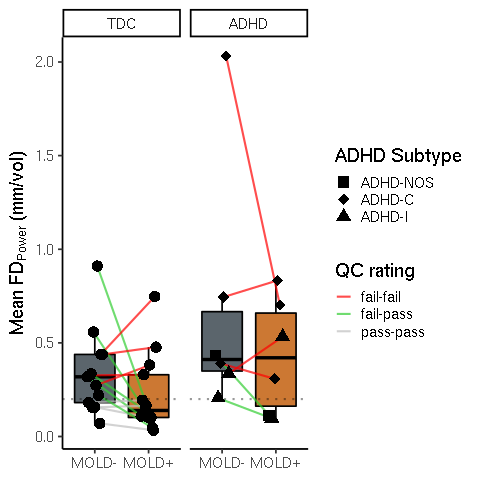

In [760]:
%%R -i fd_df -i fd_df_wide
library(likert) 
library(dplyr)
library(ggplot2)
library(ggpubr)
library(cowplot)

fd_df_wide$ADHD_Subtype[fd_df_wide$ADHD_Subtype=='']='Sub-threshold'

fd_df_wide$ADHD_Subtype <- factor(fd_df_wide$ADHD_Subtype, levels = c("Sub-threshold", "ADHD-NOS", "ADHD-C", "ADHD-I"))

fd_df_wide$dx <- factor(fd_df_wide$dx, levels = c("TDC", "ADHD"))


p1 <- merge(fd_df %>% select(sub, cond, mean_fd), fd_df_wide, by = 'sub') %>%
    rename(QC_rating = fd_rating) %>%
    ggplot(aes(x=cond, y=mean_fd)) + 
    geom_boxplot(aes(fill = cond), alpha = 0.8, size = .8, col = "black", outlier.shape = NA) +
    scale_fill_manual(values=c( '#333f48', '#BF5700')) +
    geom_line(aes(group = sub, col = QC_rating), linetype='solid', size = 1, alpha = .7, position = position_dodge(0.3)) + 
    geom_point(aes(fill=cond,group=sub, shape = ADHD_Subtype), size = 5, position = position_dodge(0.3)) +
    scale_shape_manual(breaks = c("ADHD-NOS", "ADHD-C", "ADHD-I"), values = c(16,15,18,17), "ADHD Subtype") +
    scale_colour_manual(values = c('red', 'limegreen', 'grey'), "QC rating") + theme_classic(base_size=18) +
    guides(fill = FALSE) +
    labs(y = expression(paste("Mean ",FD[Power]," (mm/vol)"))) +
    geom_hline(yintercept=.2, linetype="dotted", color = "black", size = 1, alpha = .4) +
    theme(axis.title.x = element_blank()) + facet_wrap(~ dx)

plot(p1)
# ggsave('figs/mean_fd_new.png', dpi = 300)


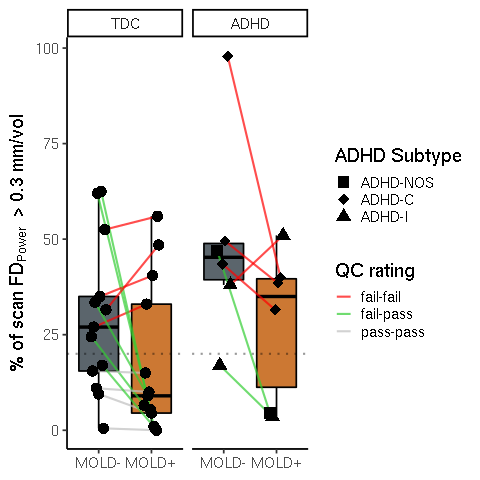

In [759]:
%%R -i fd_df_wide -i fd_df

fd_df$ADHD_Subtype[fd_df$ADHD_Subtype=='']='Sub-threshold'


fd_df$ADHD_Subtype <- factor(fd_df$ADHD_Subtype, levels = c("Sub-threshold", "ADHD-NOS", "ADHD-C", "ADHD-I"))

fd_df$dx <- factor(fd_df$dx, levels = c("TDC", "ADHD"))


p3 <- merge(fd_df, fd_df_wide %>% select(sub, perc_fd_rating), by = 'sub') %>% 
    rename(QC_rating = perc_fd_rating) %>%
    ggplot(aes(x=cond, y=perc_over_pt3)) + 
    geom_boxplot(aes(fill = cond), alpha = 0.8, size = .8, col = "black", outlier.shape = NA) +
    scale_fill_manual(values=c( '#333f48', '#BF5700')) +
    geom_line(aes(group = sub, col = QC_rating), linetype='solid', size = 1, alpha = .7, position = position_dodge(0.3)) + 
    geom_point(aes(fill=cond,group=sub, shape = ADHD_Subtype), size = 5, position = position_dodge(0.3)) +
    scale_shape_manual(breaks = c("ADHD-NOS", "ADHD-C", "ADHD-I"), values = c(16,15,18,17), "ADHD Subtype") +
    scale_colour_manual(values = c('red', 'limegreen', 'grey'), "QC rating") + theme_classic(base_size=18) +
    guides(fill = FALSE) +
    labs(y = expression(paste("% of scan ",FD[Power],"  > 0.3 mm/vol"))) +
    geom_hline(yintercept=20, linetype="dotted", color = "black", size = 1, alpha = .4) +
    theme(axis.title.x = element_blank()) + facet_wrap(~ dx)

    
# ggsave('figs/perc_fd_pt3_new.png', dpi = 300)
plot(p3)

In [775]:
%%R 
ggarrange(ggarrange(p1 , p3, common.legend = TRUE, legend = 'bottom', ncol = 2, labels=c("A","B"), font.label = list(size = 20, color = "black", face = "bold")),                                               # First row with scatter plot
          ggarrange(beeswarm + theme(legend.position = "none"), nrow = 1, labels='C', font.label = list(size = 20, color = "black", face = "bold")), # Second row with box and dot plots
          nrow = 2, heights = c(16,10))
ggsave('figs/Fig4.png', dpi = 300, width=14, height=18)

# stats

In [124]:
%%R
lme_results <- nlme::lme(mean_fd ~ cond, random = ~1 | sub, data = fd_df)
anova(lme_results)

            numDF denDF   F-value p-value
(Intercept)     1    18 243.08035  <.0001
cond            1    18  16.14628   8e-04


In [772]:
%%R
lme_results <- nlme::lme(mean_fd ~ cond*dx, random = ~1 | sub, data = fd_df)
anova(lme_results)

            numDF denDF  F-value p-value
(Intercept)     1    17 33.28419  <.0001
cond            1    17  3.27508  0.0881
dx              1    17  4.07880  0.0595
cond:dx         1    17  0.63294  0.4372


In [771]:
%%R
lme_results <- nlme::lme(mean_fd ~ cond*dx, random = ~1 | sub, data = fd_df)
anova(lme_results)

            numDF denDF  F-value p-value
(Intercept)     1    17 33.28419  <.0001
cond            1    17  3.27508  0.0881
dx              1    17  4.07880  0.0595
cond:dx         1    17  0.63294  0.4372


In [770]:
%%R
lme_results <- nlme::lme(perc_over_pt3 ~ cond, random = ~1 | sub, data = fd_df)
anova(lme_results)

            numDF denDF  F-value p-value
(Intercept)     1    18 46.72080  <.0001
cond            1    18  6.97854  0.0166


In [721]:
%%R -i fd_df
lme_results <- nlme::lme(perc_over_pt3 ~ cond*dx, random = ~1 | sub, data = fd_df)
anova(lme_results)

            numDF denDF  F-value p-value
(Intercept)     1    17 52.34533  <.0001
cond            1    17  6.80797  0.0183
dx              1    17  3.16695  0.0930
cond:dx         1    17  0.56004  0.4645


In [767]:
# paired t-test of mean_fd between MOLD- and MOLD+ conditions

from scipy.stats import ttest_rel
ttest_rel(fd_df[fd_df['cond'] == 'MOLD-']['mean_fd'], fd_df[fd_df['cond'] == 'MOLD+']['mean_fd'])

Ttest_relResult(statistic=1.8284565095401475, pvalue=0.08410212632074418)

In [774]:
# paired t-test of perc_over_pt3 between MOLD- and MOLD+ conditions

from scipy.stats import ttest_rel
ttest_rel(fd_df[fd_df['cond'] == 'MOLD-']['perc_over_pt3'], fd_df[fd_df['cond'] == 'MOLD+']['perc_over_pt3'])

Ttest_relResult(statistic=2.641692069229536, pvalue=0.016577275023268893)

In [768]:
fd_df.head()

,sub,cond,dx,mean_fd,mean_fd_scrubbed,perc_over_pt3,age,total_anxiety,ADHD_Subtype,mean_fd_transformed,rating,rating_perc_fd
0,003,MOLD+,TDC,0.108958,0.078444,6.5,10,12.0,,3.268725,1,1
1,003,MOLD-,TDC,0.318773,0.138316,24.5,10,12.0,,9.563186,0,0
2,004,MOLD-,TDC,0.181140,0.116458,15.5,7,22.0,,5.434199,1,1
3,004,MOLD+,TDC,0.193985,0.129838,15.0,7,22.0,,5.819547,1,1
4,005,MOLD-,TDC,0.326496,0.146423,27.0,9,0.0,,9.794884,0,0


## Test group difference

In [739]:
fd_df[fd_df['dx'] == 'TDC']['mean_fd']

0     0.108958
1     0.318773
2     0.181140
3     0.193985
4     0.326496
5     0.329815
6     0.334322
7     0.138985
8     0.165004
9     0.155377
10    0.121252
11    0.557805
12    0.100756
13    0.156804
14    0.273543
15    0.381553
16    0.910008
17    0.101648
18    0.220316
19    0.046971
20    0.033351
21    0.070046
22    0.439565
23    0.747519
24    0.477298
25    0.438202
Name: mean_fd, dtype: float64

In [740]:
fd_df[fd_df['dx'] == 'ADHD']['mean_fd']

26    0.432813
27    0.113372
28    0.096381
29    0.205354
30    0.307979
31    0.389668
32    0.833023
33    0.744677
34    2.031788
35    0.701389
36    0.336271
37    0.532680
Name: mean_fd, dtype: float64

In [738]:
ttest_ind(fd_df[fd_df['dx'] == 'TDC']['mean_fd'], fd_df[fd_df['dx'] == 'ADHD']['mean_fd'])

Ttest_indResult(statistic=-2.348478933795524, pvalue=0.02446061215822308)

In [741]:
from scipy.stats import levene
print(levene(fd_df[(fd_df['cond'] == 'MOLD+') & (fd_df['dx'] == 'TDC')]['mean_fd'], fd_df[(fd_df['cond'] == 'MOLD+') & (fd_df['dx'] == 'ADHD')]['mean_fd'] ))

print(ttest_ind(fd_df[(fd_df['cond'] == 'MOLD+') & (fd_df['dx'] == 'TDC')]['mean_fd'], fd_df[(fd_df['cond'] == 'MOLD+') & (fd_df['dx'] == 'ADHD')]['mean_fd'] ))

LeveneResult(statistic=2.3447568080965775, pvalue=0.14410158147309562)
Ttest_indResult(statistic=-1.721990257566475, pvalue=0.10321442962341013)


In [742]:
from scipy.stats import levene
print(levene(fd_df[(fd_df['cond'] == 'MOLD-') & (fd_df['dx'] == 'TDC')]['mean_fd'], fd_df[(fd_df['cond'] == 'MOLD-') & (fd_df['dx'] == 'ADHD')]['mean_fd'] ))

print(ttest_ind(fd_df[(fd_df['cond'] == 'MOLD-') & (fd_df['dx'] == 'TDC')]['mean_fd'], fd_df[(fd_df['cond'] == 'MOLD-') & (fd_df['dx'] == 'ADHD')]['mean_fd'] ))

LeveneResult(statistic=1.666193806184722, pvalue=0.21404825976689834)
Ttest_indResult(statistic=-1.7326196616046243, pvalue=0.10126436144136397)


## FD QA Pass/Fail

Visualize proportion of pass and fail scans based on QC threshold of FD > 0.2 mm

In [110]:
fd_df.head()

,sub,ses,cond,dx,mean_fd,mean_fd_scrubbed,perc_over_pt3
0,003,A,mold+,norm,0.108958,0.078444,6.5
1,003,B,mold-,norm,0.318773,0.138316,24.5
2,004,A,mold-,norm,0.181140,0.116458,15.5
3,004,B,mold+,norm,0.193985,0.129838,15.0
4,005,A,mold-,norm,0.326496,0.146423,27.0


In [111]:
fd_df.loc[fd_df['mean_fd'] <= .2, 'mean_fd_QA'] = 1
fd_df.loc[fd_df['mean_fd'] >= .2, 'mean_fd_QA'] = 0

In [112]:
fd_df.loc[fd_df['perc_over_pt3'] <= 20, 'perc_over_pt3_QA'] = 1
fd_df.loc[fd_df['perc_over_pt3'] >= 20, 'perc_over_pt3_QA'] = 0

In [113]:
fd_df.head()

,sub,ses,cond,dx,mean_fd,mean_fd_scrubbed,perc_over_pt3,mean_fd_QA,perc_over_pt3_QA
0,003,A,mold+,norm,0.108958,0.078444,6.5,1.0,1.0
1,003,B,mold-,norm,0.318773,0.138316,24.5,0.0,0.0
2,004,A,mold-,norm,0.181140,0.116458,15.5,1.0,1.0
3,004,B,mold+,norm,0.193985,0.129838,15.0,1.0,1.0
4,005,A,mold-,norm,0.326496,0.146423,27.0,0.0,0.0


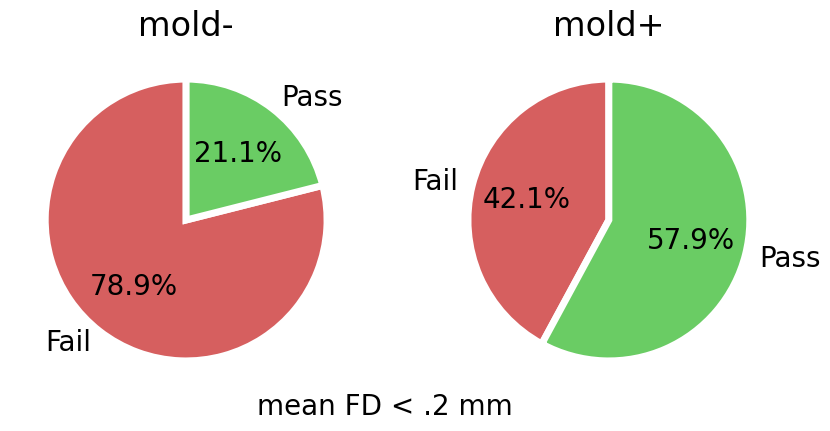

In [123]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 20, 'axes.labelweight': 'bold'})

cmap = sns.color_palette('muted')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

labels = [ 'Fail', 'Pass' ]
sizes =  fd_df.loc[fd_df['cond'] == 'mold-'].groupby('mean_fd_QA').count()['sub'].to_list()

ax1.pie(sizes, labels=labels, colors = [ cmap[3], cmap[2] ], autopct='%1.1f%%', startangle=90, pctdistance=0.60,
       wedgeprops={"edgecolor":"white",'linewidth': 5, 'antialiased': True, })
ax1.title.set_text('mold-')

sizes =  fd_df.loc[fd_df['cond'] == 'mold+'].groupby('mean_fd_QA').count()['sub'].to_list()

ax2.pie(sizes, labels=labels, colors = [ cmap[3], cmap[2] ], autopct='%1.1f%%', startangle=90, pctdistance=0.60,
       wedgeprops={"edgecolor":"white",'linewidth': 5, 'antialiased': True, })
ax2.title.set_text('mold+')

fig.text(0.5, 0.3, 'mean FD < .2 mm', ha='center', )
fig.set_facecolor('white')
plt.savefig('meanFD_QA_piechart.png', dpi = 300)
plt.show()

# correlate head motion between structural (vnav) and functional (FD) scans 
Head motion during the functional scans has been used as a proxy for motion during structural scans (Pardoe et al., 2016; Savalia et al., 2017), but has not been directly validated given the lack of estimates of head motion from structural MRI data. We tested whether fMRI head motion is suitable as a surrogate for sMRI head motion using Lin’s concordance correlation coefficient (ρc) to measure their equivalence (Lin, 1989).

In [7]:
# head motion from structural MRI
mean_rms = pd.read_csv('../../child_motion_rms_tr2.5s.csv', sep = '\t')
mean_rms['scan number'] = mean_rms['scan number'].str[:-1].apply(lambda x: x.zfill(3))

# select struct only
mean_rms = pd.melt(mean_rms[['scan number', '(s) mean-rms A (+) mm/min', '(s) mean-rms B (-) mm/min']], id_vars = 'scan number')

mean_rms = mean_rms.replace({"variable": {'(s) mean-rms A (+) mm/min': "mold+", '(s) mean-rms B (-) mm/min': "mold-"}})
mean_rms = mean_rms.rename({'scan number': 'sub', 'variable': 'cond', 'value':'mean_rms'}, axis=1) 
mean_rms['cond'] = mean_rms['cond'].map({'mold+': 'MOLD+', 'mold-': 'MOLD-'})
mean_rms = pd.merge(mean_rms, sub_coding.loc[sub_coding['ses'] == 'A'][['sub', 'dx']], on = 'sub')

mean_rms.head()



,sub,cond,mean_rms,dx
0,003,MOLD+,3.130087,TDC
1,003,MOLD-,3.493332,TDC
2,004,MOLD+,3.191968,TDC
3,004,MOLD-,4.466768,TDC
4,005,MOLD+,6.545898,TDC


In [172]:
# join struct motion with func motion

fd_df.merge(mean_rms, on = ['sub', 'cond']).query('cond == "mold+"')

,sub,cond,dx,mean_fd,mean_fd_scrubbed,perc_over_pt3,age,total_anxiety,ADHD Inattentive score,ADHD Hyperactive/Impulsive Score,age_group,meanRMS
0,003,mold+,norm,0.108958,0.078444,6.5,10.0,12.0,2.0,4.0,older,3.130087
3,004,mold+,norm,0.193985,0.129838,15.0,7.0,22.0,1.0,0.0,younger,3.191968
5,005,mold+,norm,0.329815,0.151817,33.0,9.0,0.0,NaN,NaN,older,6.545898
7,007,mold+,norm,0.138985,0.088453,9.0,8.0,18.0,0.0,1.0,older,3.764022
8,008,mold+,norm,0.165004,0.074847,10.0,5.0,1.0,0.0,0.0,younger,2.094816
10,009,mold+,norm,0.121252,0.107860,5.5,8.0,5.0,0.0,0.0,older,3.295909
12,010,mold+,norm,0.100756,0.086866,4.5,7.0,4.0,0.0,0.0,younger,2.273230
15,011,mold+,norm,0.381553,0.168220,40.5,6.0,11.0,3.0,2.0,younger,5.460302
17,012,mold+,norm,0.101648,0.098442,1.0,8.0,3.0,4.0,2.0,older,2.406943
19,013,mold+,norm,0.046971,0.045187,0.5,6.0,6.0,0.0,0.0,younger,2.839305


In [7]:
mean_rms = pd.read_csv('../../child_motion_rms_tr2.5s.csv', sep = '\t')
mean_rms['scan number'] = mean_rms['scan number'].str[:-1].apply(lambda x: x.zfill(3))

# select struct only
mean_rms = pd.melt(mean_rms[['scan number', '(s) mean-rms A (+) mm/min', '(s) mean-rms B (-) mm/min']], id_vars = 'scan number')

mean_rms = mean_rms.replace({"variable": {'(s) mean-rms A (+) mm/min': "mold+", '(s) mean-rms B (-) mm/min': "mold-"}})
mean_rms = mean_rms.rename({'scan number': 'sub', 'variable': 'cond', 'value':'mean_rms'}, axis=1) 
mean_rms['cond'] = mean_rms['cond'].map({'mold+': 'MOLD+', 'mold-': 'MOLD-'})
mean_rms = pd.merge(mean_rms, sub_coding.loc[sub_coding['ses'] == 'A'][['sub', 'dx']], on = 'sub')

mean_rms.head()

# get dx info
# mean_rms = pd.merge(mean_rms, sub_coding[['sub', 'dx']], left_on = 'scan number', right_on = 'sub')


,sub,cond,mean_rms,dx
0,003,MOLD+,3.130087,TDC
1,003,MOLD-,3.493332,TDC
2,004,MOLD+,3.191968,TDC
3,004,MOLD-,4.466768,TDC
4,005,MOLD+,6.545898,TDC


In [175]:
pearsonr(x=fd_df.merge(mean_rms, on = ['sub', 'cond']).query('cond == "mold+"')['mean_fd'], y=fd_df.merge(mean_rms, on = ['sub', 'cond']).query('cond == "mold+"')['meanRMS'])

(0.5733553919637129, 0.010276101674412126)

In [176]:
pearsonr(x=fd_df.merge(mean_rms, on = ['sub', 'cond']).query('cond == "mold-"')['mean_fd'], y=fd_df.merge(mean_rms, on = ['sub', 'cond']).query('cond == "mold-"')['meanRMS'])

(0.9639322732873715, 3.3238668602596766e-11)

In [59]:
%load_ext rpy2.ipython

In [60]:
%%R -i fd_df_j -i mean_rms
library(ggplot2)
library(DescTools)
library(ggpubr)
library(dplyr)

R[write to console]: Loading required package: magrittr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [61]:
# concordance analysis MOLD+

%%R
x = pull(mean_rms %>% subset(cond == 'mold+'), meanRMS)

y = pull(fd_df_j %>% subset(cond == 'mold+'), mean_fd_transformed)

tmp.ccc <- CCC(x, y, ci = "z-transform",
   conf.level = 0.95)

lab <- paste(expression(rho)['c'], ": ", round(tmp.ccc$rho.c[,1], digits = 2), " (95% CI ", 
   round(tmp.ccc$rho.c[,2], digits = 2), " - ",
   round(tmp.ccc$rho.c[,3], digits = 2), ")", sep = "")
z <- lm(y ~ x)

In [62]:
%%R
lab

[1] "NULL: 0.42 (95% CI 0.12 - 0.65)"


In [68]:
# concordance analysis MOLD-

%%R
x = pull(mean_rms %>% filter(cond == 'mold-' | sub != '022'), meanRMS)

y = pull(fd_df_j %>% filter(cond == 'mold-' | sub != '022'), mean_fd_transformed)

tmp.ccc <- CCC(x, y, ci = "z-transform",
   conf.level = 0.95)

lab <- paste(expression(rho)['c'], ": ", round(tmp.ccc$rho.c[,1], digits = 2), " (95% CI ", 
   round(tmp.ccc$rho.c[,2], digits = 2), " - ",
   round(tmp.ccc$rho.c[,3], digits = 2), ")", sep = "")
z <- lm(y ~ x)
lab

[1] "NULL: 0.14 (95% CI -0.18 - 0.43)"


In [538]:
# reformat condition labels

mean_rms['cond'] = mean_rms['cond'].map({'mold+': 'MOLD+', 'mold-': 'MOLD-'})

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 640x480 with 0 Axes>

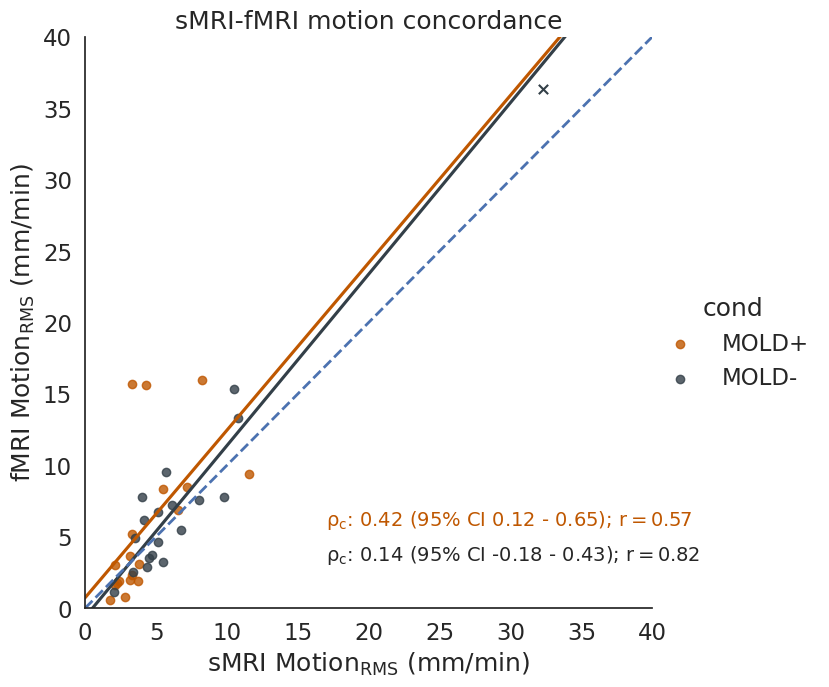

In [554]:
# drop outlier

plt.clf()
sdf = mean_rms.merge(fd_df_j[['sub','cond','mean_fd_transformed']], on = ['sub', 'cond'])
sdf = sdf[sdf['meanRMS'] <= 25] 
sns.set(font_scale=1.5)
sns.set_style("white")

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)


g = sns.FacetGrid(data=sdf, hue="cond", palette = ['#BF5700', '#333f48'], height = 7, aspect = 1)
g.set(xlim=(0, 40), ylim=(0,40))

g.map(sns.regplot, "meanRMS", "mean_fd_transformed", ci = None, truncate=False)
g.add_legend()

# g = sns.lmplot(x = 'meanRMS', y = 'mean_fd_transformed', hue='cond', height = 7, aspect = 1,
#                ci = None, truncate = False, line_kws={'label':"Reduced major axis"}, 
#                palette = ['#BF5700', '#333f48'], data = sdf)
g.set(xlabel='sMRI Motion$_{RMS}$ (mm/min)', ylabel='fMRI Motion$_{RMS}$ (mm/min)', title='sMRI-fMRI motion concordance')
# g.set(ylim=(0, 40), xlim=(0,40))

# g.axes[0,0].set_ylim(0,40)



g.fig.text(.42, .25, r'$\rho_c$: 0.42 (95% CI 0.12 - 0.65); $r = 0.57$', fontsize = 14, color = '#BF5700' )
g.fig.text(.42, .2, r'$\rho_c$: 0.14 (95% CI -0.18 - 0.43); $r = 0.82$', fontsize = 14)


plt.plot([0, 40], [0, 40], linewidth=2, ls='--', label = 'Line of perfect concordance')

plt.scatter(32.263024, 36.366131, marker = 'x', s = 45, c='#333f48') #add outlier for visualization

# plt.legend(loc="upper left")
plt.savefig('figs/concordance_drop_outlier.png', dpi = 300)
plt.show

# ROC analysis

This analysis determines the proportion of scans that would be considered sub-threshold during quality control at various threshold levels of mean FD.

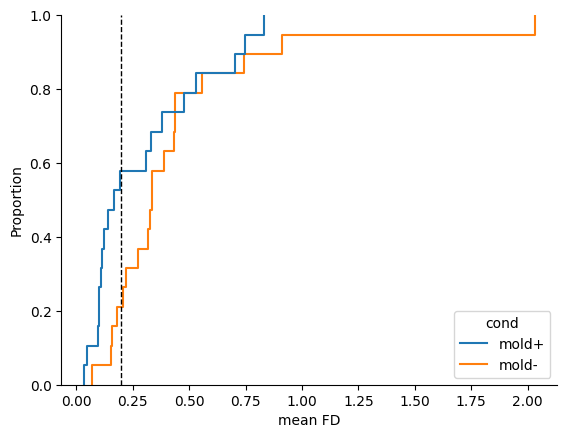

In [125]:
plt.rcdefaults()
plt.clf()
sns.ecdfplot(data=fd_df, x="mean_fd", hue="cond")
sns.despine()
sns.set_context("paper")

plt.xlabel('mean FD')
plt.xlabel('$Mean Motion_{FD}$ (mm)')

plt.axvline(.2, color='black', linestyle='--', lw = 1)

plt.tight_layout()
plt.savefig('meanfd_cdf.png', dpi = 300)

/home1/06028/tbweng/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home1/06028/tbweng/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


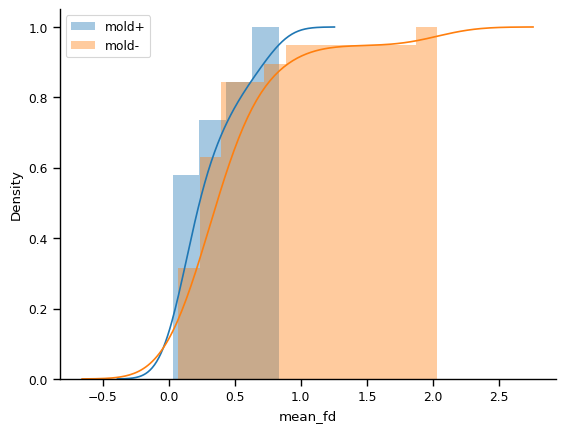

In [21]:
kwargs = {'cumulative': True}
sns.distplot(fd_df.loc[fd_df['cond'] == 'mold+']['mean_fd'], label = 'mold+', hist_kws=kwargs, kde_kws=kwargs)
sns.distplot(fd_df.loc[fd_df['cond'] == 'mold-']['mean_fd'], label = 'mold-', hist_kws=kwargs, kde_kws=kwargs)
sns.despine()
sns.set_context("paper")

plt.legend()
plt.show()

In [589]:
fd_df.head()

,sub,cond,dx,mean_fd,mean_fd_scrubbed,perc_over_pt3,age,total_anxiety,ADHD_Subtype,mean_fd_transformed,rating,rating_perc_fd
0,003,MOLD+,TDC,0.108958,0.078444,6.5,10,12.0,,3.268725,1,1
1,003,MOLD-,TDC,0.318773,0.138316,24.5,10,12.0,,9.563186,0,0
2,004,MOLD-,TDC,0.181140,0.116458,15.5,7,22.0,,5.434199,1,1
3,004,MOLD+,TDC,0.193985,0.129838,15.0,7,22.0,,5.819547,1,1
4,005,MOLD-,TDC,0.326496,0.146423,27.0,9,0.0,,9.794884,0,0


In [745]:

fd_df['age'] = [ int(a) for a in fd_df['age'] ]

In [747]:
print('MOLD- : ', np.corrcoef(fd_df[fd_df['cond'] == 'MOLD-']['age'], fd_df[fd_df['cond'] == 'MOLD-']['mean_fd'])[0][1])
print('MOLD+ : ', np.corrcoef(fd_df[fd_df['cond'] == 'MOLD+']['age'], fd_df[fd_df['cond'] == 'MOLD+']['mean_fd'])[0][1])

MOLD- :  -0.06336142220740605
MOLD+ :  -0.1444399198424551


In [755]:
from scipy.stats.stats import pearsonr

print('MOLD- : ', pearsonr(fd_df[fd_df['cond'] == 'MOLD-']['age'], fd_df[fd_df['cond'] == 'MOLD-']['mean_fd']))
print('MOLD+ : ', pearsonr(fd_df[fd_df['cond'] == 'MOLD+']['age'], fd_df[fd_df['cond'] == 'MOLD+']['mean_fd']))

MOLD- :  (-0.06336142220740604, 0.7966426764738752)
MOLD+ :  (-0.1444399198424551, 0.5552149589122024)


In [754]:
print('MOLD- : ', np.corrcoef(fd_df[fd_df['cond'] == 'MOLD-']['total_anxiety'], fd_df[fd_df['cond'] == 'MOLD-']['mean_fd'])[0][1])
print('MOLD+ : ', np.corrcoef(fd_df[fd_df['cond'] == 'MOLD+']['total_anxiety'], fd_df[fd_df['cond'] == 'MOLD+']['mean_fd'])[0][1])

MOLD- :  -0.16986896686421216
MOLD+ :  0.1051421871957132


In [753]:
from scipy.stats.stats import pearsonr

print('MOLD- : ', pearsonr(fd_df[fd_df['cond'] == 'MOLD-']['total_anxiety'], fd_df[fd_df['cond'] == 'MOLD-']['mean_fd']))
print('MOLD+ : ', pearsonr(fd_df[fd_df['cond'] == 'MOLD+']['total_anxiety'], fd_df[fd_df['cond'] == 'MOLD+']['mean_fd']))

MOLD- :  (-0.16986896686421218, 0.486896848018715)
MOLD+ :  (0.10514218719571325, 0.6683736341478241)


In [614]:
ttest_ind(fd_df[fd_df['dx'] == 'TDC']['mean_fd'], fd_df[fd_df['dx'] == 'ADHD']['mean_fd'])

Ttest_indResult(statistic=-2.348478933795524, pvalue=0.02446061215822308)